In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


from sklearn import datasets
from sklearn import metrics
from sklearn import feature_selection
from sklearn import preprocessing

from scipy import spatial
from scipy.stats import linregress
from scipy.stats import norm
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
from mpl_toolkits.mplot3d import axes3d  
from matplotlib import cm
import matplotlib.gridspec as gridspec
import math
import shap
from matplotlib.widgets import Slider, Button, RadioButtons
import seaborn as sns
from copy import deepcopy

from equadratures import *


%matplotlib notebook





In [2]:
%matplotlib

Using matplotlib backend: nbAgg


In [3]:
shap.initjs()
# Write in a function
def shap_plot(j):
    explainerModel = shap.TreeExplainer(model)
    shap_values_Model = explainerModel.shap_values(S)
    p = shap.force_plot(explainerModel.expected_value, shap_values_Model[j], S.iloc[[j]])
    return(p)

def normalise(inp):
    in_min = np.min(inp,axis=0)
    in_max = np.max(inp,axis=0)
    out = (inp-in_min)/(in_max-in_min)
    return out

def unnormalise(inp,new):
    in_min = np.min(inp,axis=0)
    in_max = np.max(inp,axis=0)
    out = in_min + new*(in_max-in_min)
    return out

def nearest_neighbour(points_a, points_b):
    tree = spatial.cKDTree(points_a)
    return tree.query(points_b)[1]

def standardise_orig(X_orig,X):
    M,d=X.shape
    X_stnd=np.zeros((M,d))
    for j in range(0,d):
        max_value = np.max(X_orig[:,j])
        min_value = np.min(X_orig[:,j])
        for i in range(0,M):
            X_stnd[i,j]=2.0 * ( (X[i,j]-min_value)/(max_value - min_value) ) -1
    return X_stnd

def unstandardise_orig(X_orig,X):
    d=X.shape[1]
    X_unstnd=np.zeros_like(X)
    for j in range(0,d):
        max_value = np.max(X_orig[:,j])
        min_value = np.min(X_orig[:,j])
        X_unstnd[:,j] = 0.5*(X[:,j] +1)*(max_value - min_value) + min_value
    return X_unstnd

def parameters(phi,psi,gc,tc):
    # Calculate flow angles 50% reaction repeating stage
    tan_alpha1 = (1-0.5-(psi/2))/phi
    tan_beta1 = tan_alpha1 - 1/phi
    beta1 = np.arctan(tan_beta1)
    tan_beta2 = tan_beta1 + psi/phi
    beta2 = np.arctan(tan_beta2)
    cos_in = np.cos(beta1)
    cos_out = np.cos(beta2)
    DH = cos_in/cos_out
    V1_U = phi/cos_in
    sc = gc/cos_in
    DF = 1 - DH + 0.5*sc*psi/V1_U
    return cos_in, cos_out, DH, V1_U, sc,DF

def angles(phi,psi):
    # Calculate flow angles 50% reaction repeating stage
    tan_alpha1 = (1-0.5-(psi/2))/phi
    tan_beta1 = tan_alpha1 - 1/phi
    beta1 = np.arctan(tan_beta1)
    tan_beta2 = tan_beta1 + psi/phi
    beta2 = np.arctan(tan_beta2)
    cos_in = np.cos(beta1)
    cos_out = np.cos(beta2)
    DH = cos_in/cos_out
    V1_U = phi/cos_in

    return cos_in, cos_out, DH, V1_U


def diffusion_factor(DF,DH,psi,V1_U):
    sc = 2*V1_U*(DF+DH -1)/psi
    return sc


def ew_loss(DF,DH,AR,ec):
    tclc = np.max([0.005*AR,ec])
    DFst = 0.4134 +0.7093*(0.16-tclc)
    DFcr = DFst - 0.015
    P = np.log(0.01176/AR)/np.log(1.3-DFst)
    G = 0.001*P/((1.3-DFcr)**(P+1))
    
    Glim = 0.06*AR/(DH**2)
    DFlim = 1.3 - (0.001*P/Glim)**(1/(P+1))
    thlim = 0.001/((1.3-DFlim)**P)
    A = (0.001 - thlim - Glim*(0.3-DFlim))/((DFlim**2)-0.6*DFlim + 0.09)
    B = Glim - 2*A*DFlim
    C = 0.001 - 0.09*A - 0.3*B
    
    loss = DF
    n = np.size(DF)
    for i in range(0,n):
        if DF[i] < 0.3:
            th = 0.001
        elif DF[i] < DFlim[i] and DF[i] >=0.3:
            th = A[i]*DF[i]**2 + B[i]*DF[i] +C[i]
        elif DF[i] >= DFlim[i] and DF[i] < DFcr:
            th = 0.001/((1.3-DF[i])**P)
        else:
            th = 0.001/((1.3-DFcr)**P) + G*(DF[i]-DFcr)
    
        loss[i] = (DH[i]**2)*(0.035 + 1.98*((ec)**1.55)+th)/AR
        
        
    return loss
        
def inv(M):
    ll, mm = M.shape
    M2 = deepcopy(M) + 1e-10 * np.eye(ll)
    L = np.linalg.cholesky(M2)
    inv_L = np.linalg.inv(L)
    inv_M = inv_L.T @ inv_L
    return inv_M    

def camber_line(dcam_le,dcam_te):
    A = np.array([[0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1],
         [1, -2, 1, 0, 0],
         [0, 0, 0, 1, 0],
         [4, 3, 2, 1, 0]])
    y = np.array([1, 0, 4, dcam_le, dcam_te])
    p = np.linalg.solve(A,y)
    return p

In [4]:
font = {'family' : 'arial',
        'weight' : 'normal',
                'size'   : 12}

plt.rc('font', **font)
plt.rcParams['savefig.dpi'] = 300

# **Load Data**

> 2D compressor data was generated using MISES. Each blade was optimised for a given design condition for 50% reaction blades. The blades are designed to have smooth flow at the LE and a linear suction surface shape factor variation to the TE.

> The variables varied and their ranges were:

1.   Flow coefficient - phi [0.3, 1.0]
2.   Stage loading coefficient - psi [0.3 1.0]
3.   Trailing edge shape factor - Hb_te [1.6, 2.3]
4.   Maximum thickness to chord - tc [0.02, 0.10]
5.   Trailing edge thickness to maximum thickness - te [0.01, 0.95]



*   The Reynolds number was fixed at 6.33*10^5 based on the true chord of the blade
*   The blade Mach number was fixed at 0.2

In [5]:
data = pd.read_csv('2D_DATA_bl_proc3.csv')

#data = data.drop(['n_gridpar', 'le_gridpar','p01','s_thick_max','N','Re','psi_stag','Alpha_error','Alpha'], axis=1)
#display(data.tail())
# Create new features of interest for later
from scipy.io import loadmat

#ind = np.linspace(43,92,50,dtype='int') RUN3
ind = np.linspace(33,82,50,dtype='int')
V_sso = data.iloc[:,ind].to_numpy()
#ind = np.linspace(93,142,50,dtype='int')
ind = np.linspace(83,132,50,dtype='int')
V_pso = data.iloc[:,ind].to_numpy()
#ind = np.linspace(143,192,50,dtype='int')
ind = np.linspace(133,182,50,dtype='int')
H_ss = data.iloc[:,ind].to_numpy()
#ind = np.linspace(193,242,50,dtype='int')
ind = np.linspace(183,232,50,dtype='int')
Th_ps = data.iloc[:,ind].to_numpy()
#ind = np.linspace(243,292,50,dtype='int')
ind = np.linspace(233,282,50,dtype='int')
Th_ss = data.iloc[:,ind].to_numpy()
#ind = np.linspace(293,342,50,dtype='int')
ind = np.linspace(283,332,50,dtype='int')
Th_ps = data.iloc[:,ind].to_numpy()
#ind = np.linspace(343,392,50,dtype='int')
ind = np.linspace(333,382,50,dtype='int')
Cf_ss = data.iloc[:,ind].to_numpy()
#ind = np.linspace(393,442,50,dtype='int')
ind = np.linspace(383,432,50,dtype='int')
Cf_ps = data.iloc[:,ind].to_numpy()



a = data['s_cp_max'].to_numpy()



# **Generate Blade Geometry**

> Blades are generated using a camber and thickness definition. This code takes the camber and thickness parameters and generates a blade shape

<IPython.core.display.Javascript object>


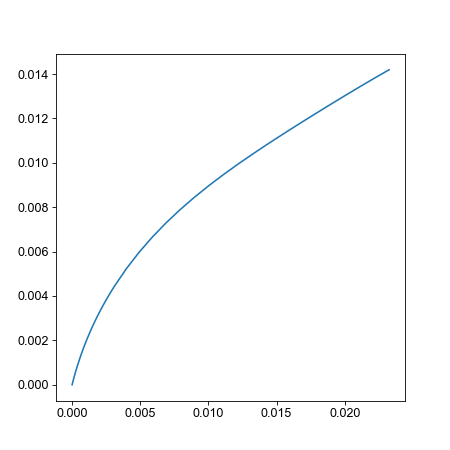

<IPython.core.display.Javascript object>


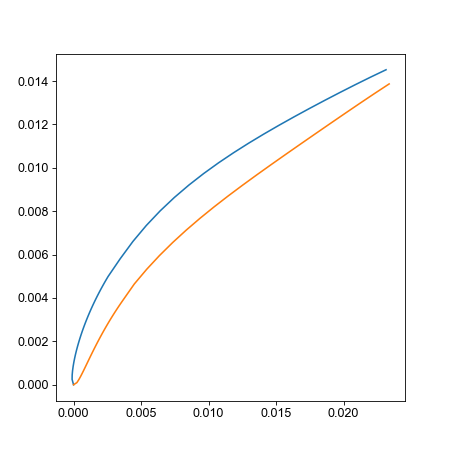

<IPython.core.display.Javascript object>


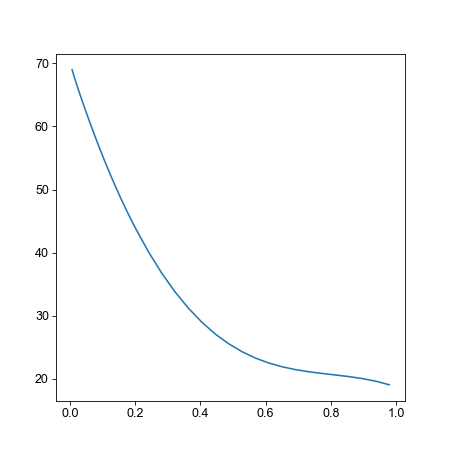

[<matplotlib.lines.Line2D at 0x13eee0d2588>]

In [7]:
def cosd(ang):
    out = np.cos(np.radians(ang))
    return out

def sind(ang):
    out = np.sin(np.radians(ang))
    return out

def tand(ang):
    out = np.tan(np.radians(ang))
    return out

def camber_line(dcam_le,dcam_te):
    A = np.array([[0, 0, 0, 0, 1],
         [1, 1, 1, 1, 1],
         [1, -2, 1, 0, 0],
         [0, 0, 0, 1, 0],
         [4, 3, 2, 1, 0]])
    y = np.array([1, 0, 4, dcam_le, dcam_te])
    p = np.linalg.solve(A,y)
    return p

def camber(dcam_le,dcam_te,chi_le,chi_te,s_cl):
    p = camber_line(dcam_le,dcam_te)
    cam = np.polyval(p,s_cl)
    chi = cam*(chi_le-chi_te) + chi_te
    x = np.cumsum(0.5*(cosd(chi[1:,0]) + cosd(chi[0:-1,0])) * np.diff(np.reshape(s_cl,(-1,)))) 
    rt = np.cumsum(0.5*(sind(chi[1:,0]) + sind(chi[0:-1,0])) * np.diff(np.reshape(s_cl,(-1,)))) 
    
    sf = 0.028 / np.sum((np.diff(x,1,0)**2 + np.diff(rt,1,0)**2)**0.5)
    x_cam = (x - x[0]) * sf 
    y_cam = (rt - rt[0])*sf

    # Coordinates on straight chord line
    x_chord = (s_cl * (x[-1] - x[0]) + x[0])*sf 
    y_chord = (s_cl * (rt[-1] - rt[0]) + rt[0]) * sf
    return chi,x,rt, x_cam, y_cam, x_chord, y_chord


def calc_thick(s_cl,x,x_f,x_r,s_j,s_split,thick_te):
    # Evaluate thickness from stretched polynomials

    # Stretch chordwise spacing of camber line points
    s_interp = s_cl;
    #s_interp[s_interp < s_split] = s_interp[s_interp < s_split] - np.polyval(x,s_interp[s_interp < s_split])

    # Evaluate polynomials at stretched spacing
    S = np.zeros(np.size(s_cl)).reshape(-1,1)
    S[s_interp <= s_j] = np.polyval(x_f,s_interp[s_interp < s_j])
    S[s_interp >= s_j] = np.polyval(x_r,s_interp[s_interp >= s_j])

    # Calculate real thickness
    thick = S * (s_cl**0.5 * (1 - s_cl)) + s_cl * thick_te
    return thick, S
    
def thickness(tc,te, s_cl):
    thick_te = te 
    s_thick_max = 0.38 
    rad_thick_max = 0.18 
    rad_le = 5 
    wedge_te = (68  - 10*(thick_te-0.01)/0.32)
    thick_max = tc*0.028 
    
    S1 = (2*rad_le)**0.5
    s2 = s_thick_max
    S2 = (1 - s2 * thick_te) / ((s2**0.5) * (1 - s2))
    a = -thick_te / ((s2**0.5) - (s2**1.5))
    b = (1 - s2 * thick_te) *  ((1/(2*(s2**0.5))) - 1.5*(s2**0.5)) / ( ((s2**0.5) -(s2**1.5))**2 )
    dSds_2 = a - b

    # Shape space curvature at max thickness point
    d2tds2_2 = -1 / rad_thick_max
    a = 2 * ((1/(2*(s2**0.5))) - 1.5*(s2**0.5)) * (-thick_te) / ( ((s2**0.5) -(s2**1.5))**2 )
    b = 2 * (((1/(2*(s2**0.5))) - 1.5*(s2**0.5))**2) / ( (s2**0.5 -s2**1.5)**3 )
    d = ( (-1 / (4*s2**1.5)) - (0.75 / (s2**0.5)) ) / ( (s2**0.5 -s2**1.5)**2 )
    d2Sds2_2 = -a + (b-d) * (1 - s2* thick_te) + d2tds2_2 / (s2**0.5 -s2**1.5)

    # Shape space trailing edge point
    S3 = tand(wedge_te) + thick_te

    # Construct shape space spline from two cubics, rear section first
    b = [[S2] , [dSds_2 ], [d2Sds2_2], [S3]]
    A = [[s2**3, s2**2, s2, 1 ], [3*s2**2, 2*s2, 1, 0 ], [6*s2, 2, 0, 0 ], [1, 1, 1, 1]]
    x_r = np.poly1d(np.linalg.solve(A,b).flatten())
    # Calculate value, gradient and curvature at join
    s_j = 0.3
    S_j = np.polyval(x_r,s_j); 
    dSds_j = np.polyval(np.polyder(x_r),s_j)
    d2Sds2_j = np.polyval(np.polyder(np.polyder(x_r)),s_j)

    # Construct cubic for front section
    s_split = 0.11 
    s_stretch = 0.08
    b = [[S1] , [S_j],  [dSds_j], [d2Sds2_j]]
    A = [[(-s_stretch)**3, (-s_stretch)**2, -s_stretch, 1 ], [s_j**3, s_j**2, s_j, 1 ], [3*s_j**2, 2*s_j, 1, 0], [6*s_j, 2, 0, 0]]
    x_f =np.poly1d(np.linalg.solve(A,b).flatten())

    # Construct stretching cubic
    A = [[0, 0, 0, 1], [s_split**3, s_split**2, s_split, 1 ], [3*s_split**2, 2*s_split, 1, 0 ], [6*s_split, 2, 0, 0]]
    b = [[s_stretch ], [0] ,[0 ], [0]]
    x = np.poly1d(np.linalg.solve(A,b).flatten())
    thick, S = calc_thick(s_cl,x,x_f,x_r,s_j,s_split,thick_te)
    return thick, S


def gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc):
    chi,x,rt,xcam,ycam, xchord, ychord = camber(dcam_le,dcam_te,chi_le,chi_te,xc)
    schord = (xchord**2 +ychord**2)**0.5
    thick, S = thickness(tc,te,xc)
    nx = -np.diff(ycam)/(np.diff(xcam)**2 +np.diff(ycam)**2)**0.5
    ny = np.diff(xcam)/(np.diff(xcam)**2 +np.diff(ycam)**2)**0.5
    thick = thick*tc*0.028
    xu = np.zeros(np.size(xcam))
    yu = np.zeros(np.size(xcam))
    xl = np.zeros(np.size(xcam))
    yl = np.zeros(np.size(xcam))
    # Construct both sides of blade from thickness and camber surface
    xu[1:] = xcam[1:] + 0.5 * nx *thick[1:-1].reshape(-1,) 
    yu[1:] = ycam[1:] + 0.5 * ny *thick[1:-1].reshape(-1,) 
    xl[1:] = xcam[1:] - 0.5 * nx *thick[1:-1].reshape(-1,) 
    yl[1:] = ycam[1:] - 0.5 * ny *thick[1:-1].reshape(-1,)
    

    return xu, yu, xl, yl, xcam,ycam, thick, chi, schord

case = 100
xu,yu,xl,yl,xcam,ycam,thick,chi, schord= gen_blade(data['dcam_le'][case],data['dcam_te'][case],data['chi_le'][case],data['chi_te'][case],data['tc'][case],data['te'][case],xc)


# **Extract Velocity Modes**

> By subtracting the mean from the velocity modes and computing PCA it is possible to deconstuct the velocity distribution into linear modes. It is important to realise looking at modes themselves is not necessarily insightful; PCA produces linear modes so while the first component may correspond to the mean linear component additional modes may correspond to additional components or non-linear corrections. The true dimensions of the problem is therefore always less than or equal to the number of modes necessary to model a problem.

In [6]:
V_ss = V_sso/data['V1'].to_numpy()[:,None]#/M1[:,None]
V_ps = V_pso/data['V1'].to_numpy()[:,None]#/M1[:,None]
istart = 0
Xo = np.hstack([V_ss[:,istart:],np.fliplr(V_ps[:,istart:])])
H = H_ss[:,istart:]
Xss = V_ss[:,istart:]
Xps = V_ps[:,istart:]
print(np.shape(Xo))
xcl = np.linspace(0,0.2,31)
xct = np.linspace(0.2,1,20)

xc = np.concatenate([xcl,xct[1:]]).reshape(-1,1)

xc1  = np.concatenate((xc[istart:,0],np.flipud(xc[istart:,0])))

x_mean_ss = np.mean(Xss,axis = 0)
x_mean_ps = np.mean(Xps,axis = 0)
x_mean = np.mean(Xo,axis = 0)
H_mean = np.mean(H,axis = 0)
#X = Xo#- VDH


Uss, Sss, VTss = np.linalg.svd(Xss-x_mean_ss)
Ups, Sps, VTps = np.linalg.svd(Xps-x_mean_ps)
U, S, VT = np.linalg.svd(Xo-x_mean)

UH, SH, HT = np.linalg.svd(H-H_mean)


(3052, 100)


# **Find Sufficient Modes**
By reconstructing the original velocity profiles from their PCA modes the integral of the velocity cubed around the blade surface can be calculated. The RMSE error of this prediction can be used as a metric to determine the number of modes necessary to predict the velocity distribution. In this case 3 modes seem sufficient. Modes for the Suction suface shape factor have also been generated.

<IPython.core.display.Javascript object>


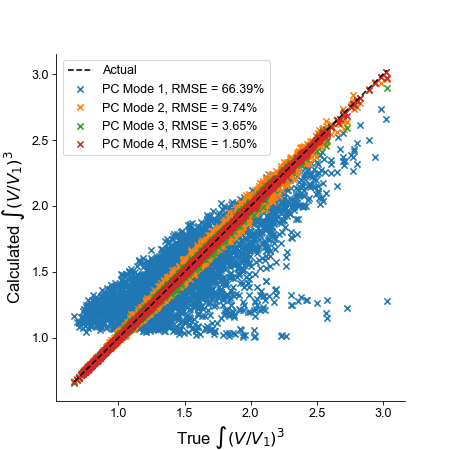

 loss  R2 = 1.0000, RMSE = 66.3937, MAE =  49.9554
 loss  R2 = 1.0000, RMSE = 9.7376, MAE =  7.6192
 loss  R2 = 1.0000, RMSE = 3.6533, MAE =  2.3895
 loss  R2 = 1.0000, RMSE = 1.5004, MAE =  1.0567


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [8]:
V3real = data['V3_V1'].to_numpy()
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax =plt.subplot(1,1,1)
plt.plot([np.min(V3real),np.max(V3real)],[np.min(V3real),np.max(V3real)],'k--',label='Actual') 
for subdim in range(1,5):
    #subdim = 5-subdim2
    active_subspace1 = VT[0:subdim,:].T
    # u is the coefficient for each mode for each data point
    u = (Xo-x_mean) @ active_subspace1
    active_subspace2 = HT[0:subdim,:].T
    # u is the coefficient for each mode for each data point
    uh = (H-H_mean) @ active_subspace2
    # reconstruct data
    orig = u@VT[0:subdim,:] 
    V = orig+x_mean
    #print(subdim)
    #print(np.shape(xc)) x=xc1[50:100].flatten()
    V3est = -np.trapz(V[:,50:100]**3, x=xc1[50:100].flatten(),axis=1) + np.trapz(V[:,0:50]**3, x=xc1[0:50].flatten(),axis=1)
    #ax = plt.subplot(4,1,subdim)
    RMSE = 100*np.sqrt(np.mean((V3real-V3est)**2))/np.std(V3real)
    MAE = 100*np.mean(np.abs(V3real-V3est))/np.std(V3real)
    R2  = metrics.r2_score(V3real,V3real)
    print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSE,MAE))
    #plt.scatter(V3real, V3est,marker='x',label='PC mode '+str(subdim) + ", RMSE = %.4f, MAE =  %.4f" %(RMSE,MAE)) 
    plt.scatter(V3real, V3est,marker='x',label='PC Mode '+str(subdim) + ", RMSE = %.2f"  %(RMSE)+"%")
    #plt.title('PC mode '+str(i+1)) 
#plt.title('V^3')     
plt.xlabel('True $\int{(V/V_{1})^3}$',fontsize=16)
plt.ylabel('Calculated $\int{(V/V_{1})^3}$',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12) 
plt.savefig('Modes.eps')

# Assign modes to data set

In [9]:
data['u1'] = u[:,0] 
data['u2'] = u[:,1]#+1.0
data['u3'] = u[:,2]#+1.0
data['u4'] = u[:,3]#+1.0

data['uh1'] = uh[:,0] 
data['uh2'] = uh[:,1]#+1.0
data['uh3'] = uh[:,2]#+1.0
data['uh4'] = uh[:,3]#+1.0



# **Learning Polynomial Models**

> Since low order structure exists within data we can use low order polynomials to model how parameters vary with respect to the initial design parameters. Sometimes the log-space is used because it enables better fits to the trends.

> An example model for learning the 'inlet flow area' g/c = s/c cos(alpha_in) is shown below. The model does not need to be perfect since we are not optimising off the predictions rather observing trends.


 $\omega_{pr}$ R2 = 0.9868, RMSE = 0.1147, MAE =  0.0681


<IPython.core.display.Javascript object>


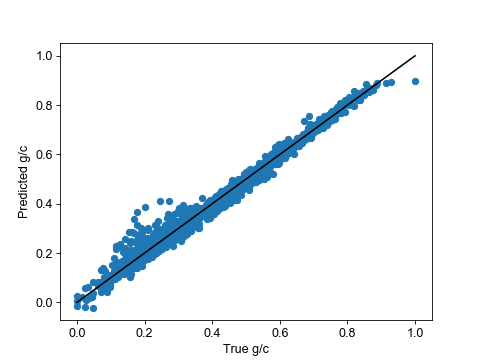

In [10]:

features = ['s','t','g','cx','camber','V1','V2','Vth1','Vth2','dV','dVth','cos_out' ,'stagger','true_stagger']
features_gc = ['phi','psi','Hb_te','tc','tec']


Xgc = np.log(data[features_gc].to_numpy())
ygc = np.log(data['gc'].to_numpy())


Xgc_range = np.log(np.vstack((np.max(data[features_gc].to_numpy(), axis=0), 
              np.min(data[features_gc].to_numpy(),axis=0))))

#Xgc = data[features_gc].to_numpy()
#ygc = data['gc'].to_numpy()


#Xgc_range = np.vstack((np.max(data[features_gc].to_numpy(), axis=0), 
#              np.min(data[features_gc].to_numpy(),axis=0)))

ynormgc = normalise(ygc)
nrow, dim = np.shape(Xgc)
X = standardise_orig(Xgc_range,Xgc)
#train, test = train_test_split(range(nrow),train_size=0.99)


# Create a polynomial as before
s1 = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparameters1 = [s1 for _ in range(0, dim)]

mybasis = Basis('total-order')
gc_model = Poly(parameters=myparameters1, basis=mybasis, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': X, 'sample-outputs': ynormgc})
gc_model.set_model()
# Check that the polynomial can aproximate the data this tests whether 
# we have sufficient information to model the variable of interest
ypred_gc = np.squeeze(gc_model.get_polyfit(X)) 
RMSE = np.sqrt(np.mean((ynormgc-ypred_gc)**2))/np.std(ynormgc)
MAE = np.mean(np.abs(ynormgc-ypred_gc))/np.std(ynormgc)
R2  = metrics.r2_score(ynormgc,ypred_gc)
print(" $\omega_{pr}$ R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSE,MAE))
fig1 = plt.figure(' g/c')
ax1 = fig1.add_subplot(111)
ax1.plot(ynormgc,ypred_gc,'o')
ax1.plot([np.min(ynormgc),np.max(ynormgc)],[np.min(ynormgc),np.max(ynormgc)],'k-')
ax1.set_xlabel('True g/c')
ax1.set_ylabel('Predicted g/c')
plt.show()

 loss  R2 = 0.9950, RMSE = 0.0164, MAE =  0.0110


<IPython.core.display.Javascript object>


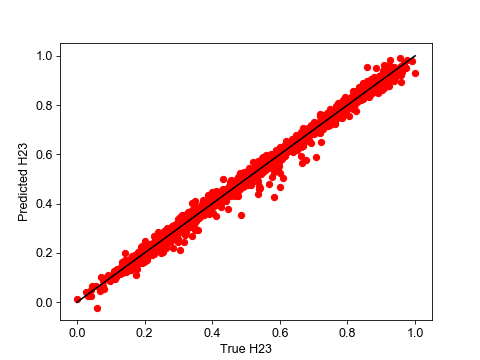

In [12]:
features_H23 = ['phi','psi','Hb_te','tc','tec']



XH23 = data[features_H23].to_numpy()
X_lim = np.vstack((np.max(data[features_H23].to_numpy(), axis=0), 
              np.min(data[features_H23].to_numpy(),axis=0)))

logX_lim_H23 = X_lim
rangelogX = logX_lim_H23[0,:]-logX_lim_H23[1,:]

yH23 = data['H23'].to_numpy()
ynormH23 = normalise(yH23)
nrow, dim = np.shape(XH23)
XH23n = standardise_orig(logX_lim_H23,XH23)

#ynormloss = yloss
nrow, dim = np.shape(XH23)
#Xl = Xloss


p_order = 3
# Create a polynomial as before
s11 = Parameter(distribution='uniform', lower=-1., upper=1., order=p_order)
myparameters11 = [s11 for _ in range(0, dim)]

mybasis1 = Basis('total-order')
H23_model = Poly(parameters=myparameters11, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': XH23n, 'sample-outputs': ynormH23})
H23_model.set_model()

ypred_H23 = np.squeeze(H23_model.get_polyfit(XH23n)) 
RMSEL = np.sqrt(np.mean((ynormH23-ypred_H23)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynormH23-ypred_H23))#/np.std(ytest)
R2  = metrics.r2_score(ynormH23,ypred_H23)

print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEL,MAE))


fig2 = plt.figure('H23')
ax2 = fig2.add_subplot(111)
ax2.plot(ynormH23,ypred_H23,'ro')


ax2.plot([np.min(ynormH23),np.max(ynormH23)],[np.min(ynormH23),np.max(ynormH23)],'k-')
ax2.set_xlabel('True H23')
ax2.set_ylabel('Predicted H23')
plt.show()

 loss  R2 = 0.9740, RMSE = 0.0207, MAE =  0.0130


<IPython.core.display.Javascript object>


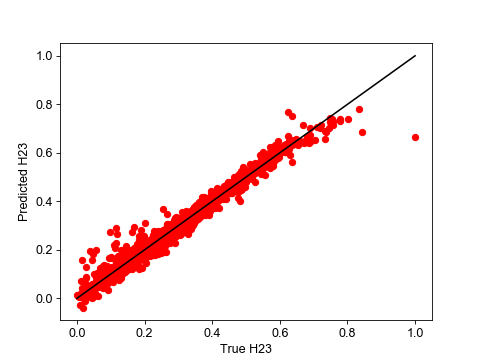

In [13]:
features_Cd = ['phi','psi','Hb_te','tc','tec']






yCd  = data['Cd'].to_numpy()
ynormCd = normalise(yCd)



#Xl = Xloss


p_order = 3
# Create a polynomial as before
s11 = Parameter(distribution='uniform', lower=-1., upper=1., order=p_order)
myparameters11 = [s11 for _ in range(0, dim)]

mybasis1 = Basis('total-order')
Cd_model = Poly(parameters=myparameters11, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': XH23n, 'sample-outputs': ynormCd})
Cd_model.set_model()

ypred_Cd = np.squeeze(Cd_model.get_polyfit(XH23n)) 
RMSEL = np.sqrt(np.mean((ynormCd-ypred_Cd)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynormCd-ypred_Cd))#/np.std(ytest)
R2  = metrics.r2_score(ynormCd,ypred_Cd)

print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEL,MAE))


fig2 = plt.figure('Cd')
ax2 = fig2.add_subplot(111)
ax2.plot(ynormCd,ypred_Cd,'ro')


ax2.plot([np.min(ynormCd),np.max(ynormCd)],[np.min(ynormCd),np.max(ynormCd)],'k-')
ax2.set_xlabel('True H23')
ax2.set_ylabel('Predicted H23')
plt.show()

# Generate loss model

 loss  R2 = 0.9960, RMSE = 0.0089, MAE =  0.0067
 loss2 R2 = 0.9804, RMSE = 0.0199, MAE =  0.0133


<IPython.core.display.Javascript object>


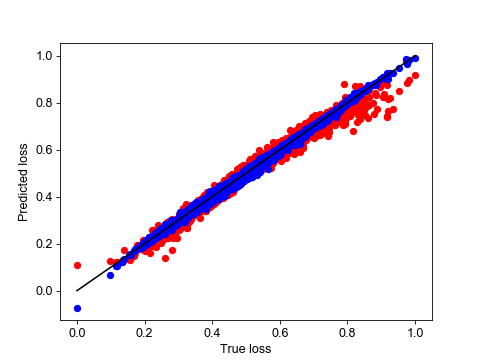

In [14]:
features2 = ['phi','psi','tc','sc','Hb_te','DH','DFl','V1','V2']
# Generate a loss model

features_loss = ['V3_V1','gc','DH','tec']


Xloss = np.log(data[features_loss].to_numpy())

X_lim = np.vstack((np.max(data[features_loss].to_numpy(), axis=0), 
              np.min(data[features_loss].to_numpy(),axis=0)))
logX_lim_loss = np.log(X_lim)
rangelogX = logX_lim_loss[0,:]-logX_lim_loss[1,:]
yloss = np.log(data['loss'].to_numpy())

ynormloss = normalise(yloss)
nrow, dim = np.shape(Xloss)
Xl = standardise_orig(logX_lim_loss,Xloss)

#ynormloss = yloss
nrow, dim = np.shape(Xloss)
#Xl = Xloss


p_order = 3
# Create a polynomial as before
s11 = Parameter(distribution='uniform', lower=-1., upper=1., order=p_order)
myparameters11 = [s11 for _ in range(0, dim)]

mybasis1 = Basis('total-order')
loss_model = Poly(parameters=myparameters11, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xl, 'sample-outputs': ynormloss})
loss_model.set_model()



# Check that the polynomial can aproximate the data this tests whether 
# we have sufficient information to model the variable of interest
ypred_loss = np.squeeze(loss_model.get_polyfit(Xl)) 
error = np.abs((ynormloss-ypred_loss)/(ynormloss+0.001))
R2 = linregress(ynormloss, ypred_loss)[2]

# Using sc model
data['gc_pred'] = np.exp(unnormalise(ygc,ypred_gc))
#data['gc_pred'] = unnormalise(ygc,ypred_gc)
data.head()
features_loss2 = ['V3_V1','gc_pred','DH','tec']
Xloss2 = np.log(data[features_loss2].to_numpy())
Xl2 = standardise_orig(logX_lim_loss,Xloss2)
#Xl2 = Xloss2

ypred_loss2 = np.squeeze(loss_model.get_polyfit(Xl2)) 
RMSEL = np.sqrt(np.mean((ynormloss-ypred_loss)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynormloss-ypred_loss))#/np.std(ytest)
R2  = metrics.r2_score(ynormloss,ypred_loss)

RMSE2 = np.sqrt(np.mean((ynormloss-ypred_loss2)**2))#/np.std(ytest)
MAE2 = np.mean(np.abs(ynormloss-ypred_loss2))#/np.std(ytest)
R22  = metrics.r2_score(ynormloss,ypred_loss2)
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEL,MAE))
print(" loss2 R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R22,RMSE2,MAE2))
R22 = linregress(ynormloss, ypred_loss2)[2]

fig2 = plt.figure('loss')
ax2 = fig2.add_subplot(111)
ax2.plot(ynormloss,ypred_loss2,'ro')
ax2.plot(ynormloss,ypred_loss,'bo')

ax2.plot([np.min(ynormloss),np.max(ynormloss)],[np.min(ynormloss),np.max(ynormloss)],'k-')
ax2.set_xlabel('True loss')
ax2.set_ylabel('Predicted loss')
plt.show()
# The results of this show that the sc_model is good enough to use as a replacement for Hb_te

# **Calculating Uncertainty**
> To assess how valid the models are at capturing the physics the uncertainty can be calculated.

In [11]:
# Create the model for predictig velocity and loss bsed on design parameters
def uncertainy_model(model,N,RMSE):
    noise_variance = RMSE**2 * np.ones(N)
    Sigma = np.diag(noise_variance) # a diagonal matrix need not be assumed.


    # On the training data! 
    P = model.get_poly(model._quadrature_points)
    
    W = np.diag(np.sqrt(model._quadrature_weights))
    A = np.dot(W, P.T)
    Q = np.dot( inv( np.dot(A.T, A) ), A.T)
    return Q, Sigma

def predict_uncertainty(model,X,Sigma,Q):
    # On the testing data (omit weights!)
    Po = model.get_poly(X)
    Ao = Po.T

    # Propagating the uncertainties!
    Sigma_X = np.dot( np.dot(Q, Sigma), Q.T)
    Sigma_F = np.dot( np.dot(Ao, Sigma_X), Ao.T) 
    two_std_F = 1.96 * np.sqrt( np.diag(Sigma_F) )
    #print(a[isamp,:])
    return two_std_F

# Plot of uncertainty in the loss model

<IPython.core.display.Javascript object>


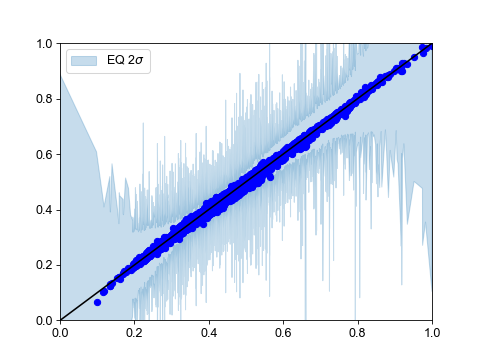

In [15]:
Qloss,Sigloss = uncertainy_model(loss_model,len(yloss),RMSEL)
two_std_F = predict_uncertainty(loss_model,Xl,Sigloss,Qloss)
ind=np.argsort(ynormloss) 
# Plot!
fig = plt.figure()
ax = fig.add_subplot(111)
#ax.plot(x, y, 'ro',label='Training points w/ 2$\sigma$ errors')
#ax.errorbar(x, y, 1.96 * np.sqrt(noise_variance), fmt='ro', ecolor='k', capthick=1, capsize=8)
ax.fill_between(ynormloss[ind], ypred_loss[ind]+two_std_F[ind], ypred_loss[ind]-two_std_F[ind], alpha=.25,color='C0',label='EQ 2$\sigma$')
ax.plot(ynormloss[ind],ypred_loss[ind],'bo')
ax.plot([np.min(ynormloss),np.max(ynormloss)],[np.min(ynormloss),np.max(ynormloss)],'k-')
ax.axis('tight')
ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.legend()
plt.show()

# Create model for velocity modes

Using the same principle we can produce low order polynomial models for each of the velocity modes extracted using PCA. We can check their accuracy by plotting their predictions

 loss  R2 = 0.9987, RMSE = 0.0092, MAE =  0.0067


<IPython.core.display.Javascript object>


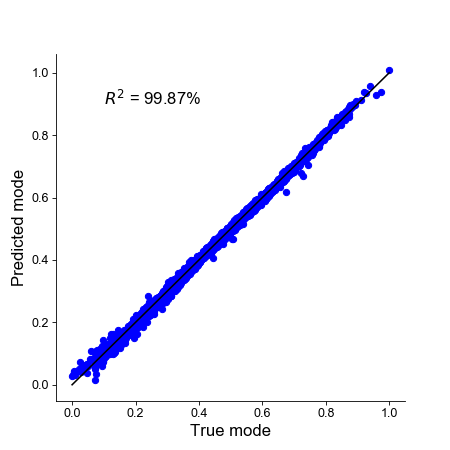

 loss  R2 = 0.9916, RMSE = 0.0172, MAE =  0.0098


<IPython.core.display.Javascript object>


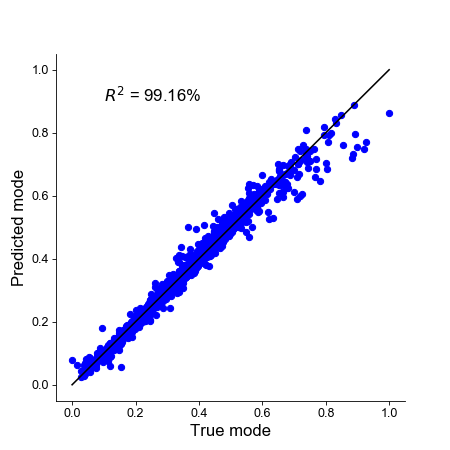

 loss  R2 = 0.9941, RMSE = 0.0174, MAE =  0.0125


<IPython.core.display.Javascript object>


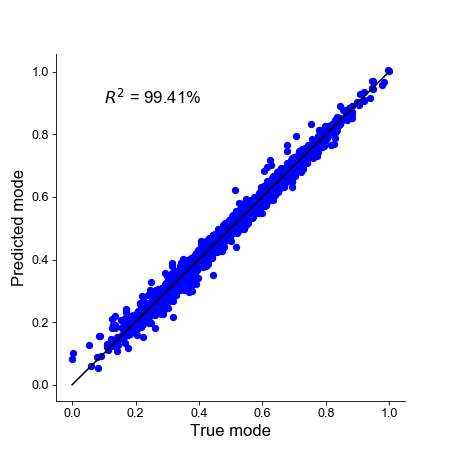

 loss  R2 = 0.9908, RMSE = 0.0221, MAE =  0.0158


<IPython.core.display.Javascript object>


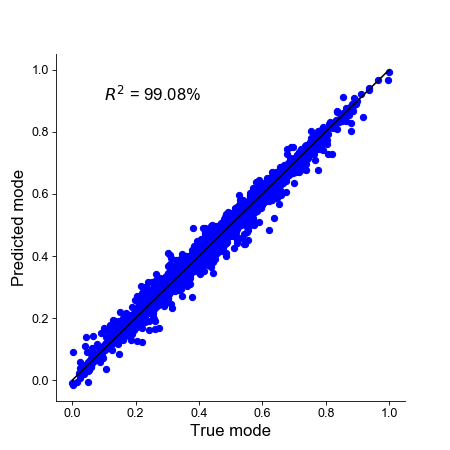

In [16]:
features_u = ['phi','psi','gc','tc','tec','DH']
#features_u = ['phi','psi','gc','tc','tec']


#Xuss1 = np.log(data[features_uss1].to_numpy())

X_lim_u = np.vstack((np.max(data[features_u].to_numpy(), axis=0), 
              np.min(data[features_u].to_numpy(),axis=0)))
#logX_lim_uss1 = np.log(X_lim_uss1)

Xu = data[features_u].to_numpy()

#rangelogX = logX_lim_u[0,:]-logX_lim_u[1,:]
#yuss1 = np.log(data['uss1'].to_numpy())

nrow, dim = np.shape(Xu)
Xun = standardise_orig(X_lim_u ,Xu)



yuss1 = data['u1'].to_numpy()
ynormuss1 = normalise(yuss1)
yuss2 = data['u2'].to_numpy()
ynormuss2 = normalise(yuss2)
yuss3 = data['u3'].to_numpy()
ynormuss3 = normalise(yuss3)
yuss4 = data['u4'].to_numpy()
ynormuss4 = normalise(yuss4)



# Create a polynomial as before
su = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [su for _ in range(0, dim)]

mybasis1 = Basis('total-order')
uss1_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuss1})
uss1_model.set_model()
su = Parameter(distribution='uniform', lower=-1., upper=1., order=4)
myparametersu = [su for _ in range(0, dim)]
uss2_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuss2})
uss2_model.set_model()

uss3_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuss3})
uss3_model.set_model()

uss4_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuss4})
uss4_model.set_model()



# Check that the polynomial can aproximate the data this tests whether 
# we have sufficient information to model the variable of interest
ypred = np.squeeze(uss1_model.get_polyfit(Xun)) 
ynorm = ynormuss1
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('Mode 1',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode1.eps')

ypred = np.squeeze(uss2_model.get_polyfit(Xun)) 
ynorm = ynormuss2
RMSEU2 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU2,MAE))
fig2 = plt.figure('Mode 2',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode2.eps')


ypred = np.squeeze(uss3_model.get_polyfit(Xun)) 
ynorm = ynormuss3
RMSEU3 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU3,MAE))
fig2 = plt.figure('Mode 3',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode3.eps')
ypred = np.squeeze(uss4_model.get_polyfit(Xun)) 
ynorm = ynormuss4
RMSEU4 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU4,MAE))
fig2 = plt.figure('Mode 4',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()


QU1,SigU1 = uncertainy_model(uss1_model,len(yloss),RMSEU1)
QU2,SigU2 = uncertainy_model(uss2_model,len(yloss),RMSEU2)
QU3,SigU3 = uncertainy_model(uss3_model,len(yloss),RMSEU3)
QU4,SigU4 = uncertainy_model(uss4_model,len(yloss),RMSEU4)

 loss  R2 = 0.9889, RMSE = 0.0289, MAE =  0.0209


<IPython.core.display.Javascript object>


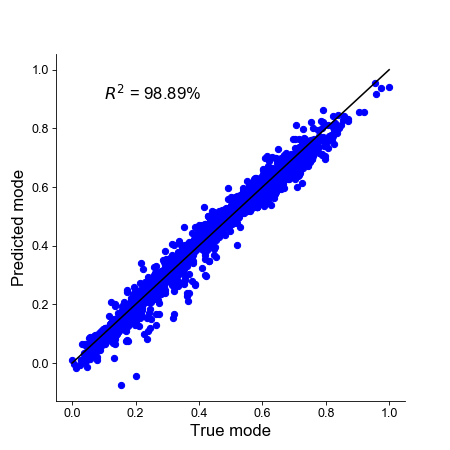

 loss  R2 = 0.9948, RMSE = 0.0135, MAE =  0.0089


<IPython.core.display.Javascript object>


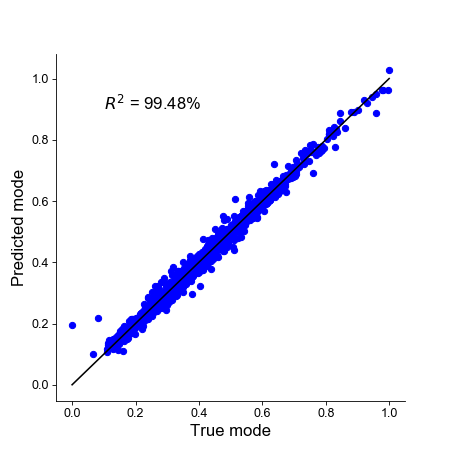

 loss  R2 = 0.9838, RMSE = 0.0168, MAE =  0.0113


<IPython.core.display.Javascript object>


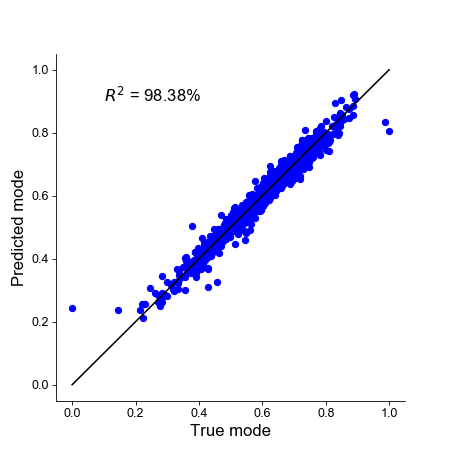

 loss  R2 = 0.9794, RMSE = 0.0220, MAE =  0.0143


<IPython.core.display.Javascript object>


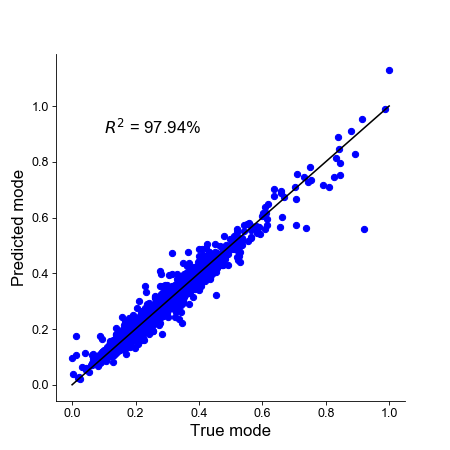

In [17]:
features_u = ['phi','psi','gc','tc','tec','DH']
#features_u = ['phi','psi','gc','tc','tec']


#Xuss1 = np.log(data[features_uss1].to_numpy())

X_lim_u = np.vstack((np.max(data[features_u].to_numpy(), axis=0), 
              np.min(data[features_u].to_numpy(),axis=0)))
#logX_lim_uss1 = np.log(X_lim_uss1)

Xu = data[features_u].to_numpy()

#rangelogX = logX_lim_u[0,:]-logX_lim_u[1,:]
#yuss1 = np.log(data['uss1'].to_numpy())

nrow, dim = np.shape(Xu)
Xun = standardise_orig(X_lim_u ,Xu)



yuh1 = data['uh1'].to_numpy()
ynormuh1 = normalise(yuh1)
yuh2 = data['uh2'].to_numpy()
ynormuh2 = normalise(yuh2)
yuh3 = data['uh3'].to_numpy()
ynormuh3 = normalise(yuh3)
yuh4 = data['uh4'].to_numpy()
ynormuh4 = normalise(yuh4)



# Create a polynomial as before
su = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [su for _ in range(0, dim)]

mybasis1 = Basis('total-order')
uh1_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuh1})
uh1_model.set_model()
su = Parameter(distribution='uniform', lower=-1., upper=1., order=4)
myparametersu = [su for _ in range(0, dim)]
uh2_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuh2})
uh2_model.set_model()

uh3_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuh3})
uh3_model.set_model()

uh4_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xun, 'sample-outputs': ynormuh4})
uh4_model.set_model()

# Check that the polynomial can aproximate the data this tests whether 
# we have sufficient information to model the variable of interest
ypred = np.squeeze(uh1_model.get_polyfit(Xun)) 
ynorm = ynormuh1
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('H Mode 1',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode1.eps')

ypred = np.squeeze(uh2_model.get_polyfit(Xun)) 
ynorm = ynormuh2
RMSEU2 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU2,MAE))
fig2 = plt.figure('H Mode 2',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode2.eps')


ypred = np.squeeze(uh3_model.get_polyfit(Xun)) 
ynorm = ynormuh3
RMSEU3 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU3,MAE))
fig2 = plt.figure('H Mode 3',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('mode3.eps')
ypred = np.squeeze(uh4_model.get_polyfit(Xun)) 
ynorm = ynormuh4
RMSEU4 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU4,MAE))
fig2 = plt.figure(' H Mode 4',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True mode',fontsize=16)
ax2.set_ylabel('Predicted mode',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()

# **Bringing It All Together**

> We can combine these models to allow us predict parameters based on different combinations of input parameters. This allows us to change how we think about the 'design space'. Below are a few different ways of implementing predictions.

In [18]:
def predict_V(phi,psi,H,tc,te):
    global x_mean, X_lim_u, logX_lim_loss, Xgc_range, yloss, xc1, yCd, yH23
    # Run the pitch model to get sample estimate

    tec = te*tc
    
    Xsamp = np.concatenate((np.array(phi).reshape((-1,1)),np.array(psi).reshape((-1,1)), 
                    np.array(H).reshape((-1,1)),np.array(tc).reshape((-1,1)),np.array(tec).reshape((-1,1))),axis=1)

    Xsamp_gc = standardise_orig(Xgc_range,np.log(Xsamp))
    Xsamp_H23 = standardise_orig(logX_lim_H23,Xsamp)
    
    ysamp_gc = np.squeeze(gc_model.get_polyfit(Xsamp_gc ))
    gc = np.exp(unnormalise(ygc,ysamp_gc))
    
    H23 = unnormalise(yH23,np.squeeze(H23_model.get_polyfit(Xsamp_H23 )))
    Cd = unnormalise(yCd,np.squeeze(Cd_model.get_polyfit(Xsamp_H23 )))
    
    # Calculate other variables
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(phi,psi,gc,tc)
    Xsamp_u2 = np.array([phi,psi,gc,tc,te*tc,DH]).reshape((-1,6))
    Xsamp_u2 = np.concatenate((np.array(phi).reshape((-1,1)),np.array(psi).reshape((-1,1)), 
                    gc.reshape((-1,1)),np.array(tc).reshape((-1,1)),np.array(tec).reshape((-1,1)),DH.reshape((-1,1))),axis=1)
   
    Xsamp_un2 = standardise_orig(X_lim_u,Xsamp_u2)
    
    u1_pred = unnormalise(yuss1,np.squeeze(uss1_model.get_polyfit(Xsamp_un2)))
    u2_pred = unnormalise(yuss2,np.squeeze(uss2_model.get_polyfit(Xsamp_un2)))
    u3_pred = unnormalise(yuss3,np.squeeze(uss3_model.get_polyfit(Xsamp_un2)))
    #u4_pred = unnormalise(yuss4,np.squeeze(uss4_model.get_polyfit(Xsamp_un2)))

    u_pred = np.concatenate((u1_pred.reshape((-1,1)),u2_pred.reshape((-1,1)), 
                    u3_pred.reshape((-1,1))),axis=1)
    
    u1_unc = unnormalise(yuss1,predict_uncertainty(uss1_model,Xsamp_un2,SigU1,QU1)) - np.min(yuss1)
    u2_unc = unnormalise(yuss2,predict_uncertainty(uss2_model,Xsamp_un2,SigU2,QU2)) - np.min(yuss2)
    u3_unc = unnormalise(yuss3,predict_uncertainty(uss3_model,Xsamp_un2,SigU3,QU3)) - np.min(yuss3)
    #u4_unc = unnormalise(yuss4,predict_uncertainty(uss4_model,Xsamp_un2,SigU4,QU4)) - np.min(yuss4)
    u_unc = np.concatenate((u1_unc.reshape((-1,1)),u2_unc.reshape((-1,1)), 
                    u3_unc.reshape((-1,1))),axis=1)
    V_p = u_pred[:,0:3]@VT[0:3,:] + x_mean
    V_un = u_unc[:,0:3]@abs(VT[0:3,:])
    a =  Xu[:,0:4]
    b = Xsamp_u2[0,0:4]
   
    isamp = nearest_neighbour(a, b)
    
    V3est = -np.trapz(V_p[:,50:100]**3, x=xc1[50:100].flatten(),axis=1) + np.trapz(V_p[:,0:50]**3, x=xc1[0:50].flatten(),axis=1)
    
    Xtest = np.concatenate((V3est.reshape((-1,1)),gc.reshape((-1,1)), 
                    DH.reshape((-1,1)),np.array(tec).reshape((-1,1))),axis=1)
    Xtest2 = standardise_orig(logX_lim_loss,np.log(Xtest))
    Yloss = np.squeeze(loss_model.get_polyfit(Xtest2 ))


    loss = np.exp(unnormalise(yloss,Yloss))
    
    
    
    
    
    #loss_err = np.exp(predict_uncertainty(loss_model,Xtest2,Yloss))
    #print(a[isamp,:])
    return V_p, isamp, loss,sc, DH, V1_U,V_un, V3est, H23, Cd


def predict_Hss(phi,psi,H,tc,te):
    global H_mean, X_lim_u, logX_lim_loss, Xgc_range, yloss, xc1, yCd, yH23
    # Run the pitch model to get sample estimate

    tec = te*tc
    
    Xsamp = np.concatenate((np.array(phi).reshape((-1,1)),np.array(psi).reshape((-1,1)), 
                    np.array(H).reshape((-1,1)),np.array(tc).reshape((-1,1)),np.array(tec).reshape((-1,1))),axis=1)

    Xsamp_gc = standardise_orig(Xgc_range,np.log(Xsamp))
    Xsamp_H23 = standardise_orig(logX_lim_H23,Xsamp)
    
    ysamp_gc = np.squeeze(gc_model.get_polyfit(Xsamp_gc ))
    gc = np.exp(unnormalise(ygc,ysamp_gc))
    
    H23 = unnormalise(yH23,np.squeeze(H23_model.get_polyfit(Xsamp_H23 )))
    Cd = unnormalise(yCd,np.squeeze(Cd_model.get_polyfit(Xsamp_H23 )))
    
    # Calculate other variables
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(phi,psi,gc,tc)
    Xsamp_u2 = np.array([phi,psi,gc,tc,te*tc,DH]).reshape((-1,6))
    Xsamp_u2 = np.concatenate((np.array(phi).reshape((-1,1)),np.array(psi).reshape((-1,1)), 
                    gc.reshape((-1,1)),np.array(tc).reshape((-1,1)),np.array(tec).reshape((-1,1)),DH.reshape((-1,1))),axis=1)
   
    Xsamp_un2 = standardise_orig(X_lim_u,Xsamp_u2)
    
    u1_pred = unnormalise(yuh1,np.squeeze(uh1_model.get_polyfit(Xsamp_un2)))
    u2_pred = unnormalise(yuh2,np.squeeze(uh2_model.get_polyfit(Xsamp_un2)))
    u3_pred = unnormalise(yuh3,np.squeeze(uh3_model.get_polyfit(Xsamp_un2)))
    #u4_pred = unnormalise(yuss4,np.squeeze(uss4_model.get_polyfit(Xsamp_un2)))

    u_pred = np.concatenate((u1_pred.reshape((-1,1)),u2_pred.reshape((-1,1)), 
                    u3_pred.reshape((-1,1))),axis=1)
    

    H_ss = u_pred[:,0:3]@HT[0:3,:] + H_mean

    
    
    
    
    
    #loss_err = np.exp(predict_uncertainty(loss_model,Xtest2,Yloss))
    #print(a[isamp,:])
    return H_ss



def predict_V_gc(phi,psi,gc,tc,te):
    global x_mean, xc1, X_lim_u, yuss1, yuss2, yuss3, logX_lim_loss,yloss
    # Calculate other variables
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(phi,psi,gc,tc)
    tec = te*tc
    Xsamp_u2 = np.concatenate((np.array(phi).reshape((-1,1)),np.array(psi).reshape((-1,1)), 
                    np.array(gc).reshape((-1,1)),np.array(tc).reshape((-1,1)),np.array(tec).reshape((-1,1)),DH.reshape((-1,1))),axis=1)
    Xsamp_un2 = standardise_orig(X_lim_u,Xsamp_u2)
    
    u1_pred = unnormalise(yuss1,np.squeeze(uss1_model.get_polyfit(Xsamp_un2)))
    u2_pred = unnormalise(yuss2,np.squeeze(uss2_model.get_polyfit(Xsamp_un2)))
    u3_pred = unnormalise(yuss3,np.squeeze(uss3_model.get_polyfit(Xsamp_un2)))
    #u4_pred = unnormalise(yuss4,np.squeeze(uss4_model.get_polyfit(Xsamp_un2)))
    #u5_pred = unnormalise(yuss5,np.squeeze(uss4_model.get_polyfit(Xsamp_un2)))
    u_pred = np.concatenate((u1_pred.reshape((-1,1)),u2_pred.reshape((-1,1)), 
                    u3_pred.reshape((-1,1))),axis=1)
    
    #unnormalise(yuss1,predict_uncertainty(uss1_model,Xsamp_un2,u1_pred))
    u1_unc = unnormalise(yuss1,predict_uncertainty(uss1_model,Xsamp_un2,SigU1,QU1)) - np.min(yuss1)
    u2_unc = unnormalise(yuss2,predict_uncertainty(uss2_model,Xsamp_un2,SigU2,QU2)) - np.min(yuss2)
    u3_unc = unnormalise(yuss3,predict_uncertainty(uss3_model,Xsamp_un2,SigU3,QU3)) - np.min(yuss3)
    #u4_unc = unnormalise(yuss4,predict_uncertainty(uss4_model,Xsamp_un2,SigU4,QU4)) - np.min(yuss4)
    u_unc = np.concatenate((u1_unc.reshape((-1,1)),u2_unc.reshape((-1,1)), 
                    u3_unc.reshape((-1,1))),axis=1)
    V_p = u_pred[:,0:3]@VT[0:3,:] + x_mean
    V_un = u_unc[:,0:3]@abs(VT[0:3,:])
    
    a =  Xu[:,0:4]
    b = Xsamp_u2[0,0:4]
   
    isamp = nearest_neighbour(a, b)
    V3est = -np.trapz(V_p[:,50:100]**3, x=xc1[50:100].flatten(),axis=1) + np.trapz(V_p[:,0:50]**3, x=xc1[0:50].flatten(),axis=1)
    Xtest = np.concatenate((V3est.reshape((-1,1)),np.array(gc).reshape((-1,1)), 
                    DH.reshape((-1,1)),np.array(tec).reshape((-1,1))),axis=1)
    Xtest2 = standardise_orig(logX_lim_loss,np.log(Xtest))
    Yloss = np.squeeze(loss_model.get_polyfit(Xtest2 ))


    loss = np.exp(unnormalise(yloss,Yloss))
   # loss_err = np.exp(predict_uncertainty(loss_model,Xtest2,Yloss))
    #print(a[isamp,:])
    return V_p, isamp, loss,sc, DH, V1_U,V_un, V3est

def predict_loss(phi,psi,H,tc,te):
    global loss_model, yloss,Sigloss,QlossL
    tec = te*tc
    # Run the pitch model to get sample estimate
    Xsamp = np.concatenate((phi.reshape((-1,1)),psi.reshape((-1,1)),H.reshape((-1,1)),
                            tc.reshape((-1,1)),tec.reshape((-1,1))), axis = 1)
    Xsamp_gc = standardise_orig(Xgc_range,np.log(Xsamp))
    
    ysamp_gc = np.squeeze(gc_model.get_polyfit(Xsamp_gc ))
    gc = np.exp(unnormalise(ygc,ysamp_gc))
    # Calculate other variables
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(phi,psi,gc,tc)


    
    Xtest = np.concatenate((V3.reshape((-1,1)),gc.reshape((-1,1)),
                            DH.reshape((-1,1)),tec.reshape((-1,1))), axis = 1)

    Xtest2 = standardise_orig(logX_lim,np.log(Xtest))
    Yloss = np.squeeze(loss_model.get_polyfit(Xtest2 ))


    loss = np.exp(unnormalise(yloss,Yloss))
    log_unc = unnormalise(yloss,predict_uncertainty(loss_model,Xtest2,Sigloss,Qloss)) - np.min(yloss)
    #print(log_unc)
    loss_err = log_unc
    #print(a[isamp,:])
    return loss,sc, DH, V1_U,loss_err


def sample_smith(H,tc,te,N,AR,ec):

    # Creat subset of data for thin aerofoil analysis
    nsamp = N*N
    # Sample test input parameters for the search space
    max_min = np.array([[1.0, 1.0, H, tc,te],
              [0.3, 0.3,H,  tc,te]])

    dim = 5
    Xsamples = np.random.rand(nsamp,dim)
    for i in range(0,dim):
        max_X = max_min[0,i]
        min_X = max_min[1,i]
        range_X =  max_X - min_X
        Xsamples[:,i] =  range_X*Xsamples[:,i] + min_X

    #print(Xsamples)
    #Conversion to te/c from te/t    
    #Xsamples[:,4] = Xsamples[:,3]*Xsamples[:,4]

    # overwirting for structured smith chart
    phi_samples = np.linspace(max_min[1,0], max_min[0,0], N)
    psi_samples = np.linspace(max_min[1,1], max_min[0,1], N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1)) 
    Xsamples[:,0] = PHI_vec.flatten()
    Xsamples[:,1] = PSI_vec.flatten()
    #loss = np.zeros(np.shape(Xsamples[:,0]))
   # DH = np.zeros(np.shape(Xsamples[:,0]))
    #sc = np.zeros(np.shape(Xsamples[:,0]))
   # V1_U = np.zeros(np.shape(Xsamples[:,0]))
    print(np.shape(Xsamples[:,0]))
    V_p, isamp, loss,sc, DH, V1_U,V_un, V3est, H23,Cd = predict_V(Xsamples[:,0],Xsamples[:,1],Xsamples[:,2],Xsamples[:,3],Xsamples[:,4])
    #for i in range(0,nsamp):
    #    V_p, isamp, loss[i],sc[i], DH[i], V1_U[i],V_un, V3est = predict_V(Xsamples[i,0],Xsamples[i,1],Xsamples[i,2],Xsamples[i,3],Xsamples[i,4])
    #loss,sc,DH,V1_U,loss_err= predict_loss(Xsamples[:,0],Xsamples[:,1],Xsamples[:,2],Xsamples[:,3],Xsamples[:,4])
    [cos_in, cos_out, DH, V1_U]=angles(Xsamples[:,0],Xsamples[:,1])
    gc = sc*cos_in
    #V_p, isamp, loss,sc, DH, V1_U,V_un = predict_V_gc(Xsamples[:,0],Xsamples[:,1],gc,Xsamples[:,3],Xsamples[:,4])
    EC = ec*np.ones((N*N,1 ))
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(Xsamples[:,0],Xsamples[:,1],gc,Xsamples[:,3])
    beta = np.array([0.06925694,
            -0.78955089,
    4.79552054,
    -11.28834548,
    9.36594389,
    63.42547887,
    -614.56718287,
    2204.62301995,
    -3470.72680381,
    2034.16092926,
    -1479.23330237,
    12818.31717717,
    -38223.81950502,
    43618.99593009,
    -12516.48005119,
    4165.78162138,
    -20645.77804574,
    -18322.84464532,
    216305.10857349,
    -266162.66625881])
    #D = np.array([1, DF, DF**2, DF**3, DF**4, EC, EC*DF, EC*DF**2, EC*DF**3, EC*DF**4,EC**2,(EC**2)*DF,
    #     (EC**2)*DF**2, (EC**2)*DF**3, (EC**2)*DF**4, (EC**3), (EC**3)*DF, (EC**3)*DF**2, (EC**3)*DF**3, (EC**3)*DF**4])
    DF2 = DF.reshape((-1,1))
    
    D = np.concatenate((np.ones((N*N,1 )), DF2, DF2**2, DF2**3, DF2**4, EC, EC*DF2, EC*DF2**2, EC*DF2**3, EC*DF2**4,EC**2,(EC**2)*DF2,
         (EC**2)*DF2**2, (EC**2)*DF2**3, (EC**2)*DF2**4, (EC**3), (EC**3)*DF2, (EC**3)*DF2**2, (EC**3)*DF2**3, (EC**3)*DF2**4), axis = 1)
    ELP = D@beta.reshape((-1,1))
    print(np.shape(D), np.shape(ELP),np.shape(beta))
    loss_ew = ((ELP.reshape((-1,))*DH**2)/AR).reshape((-1,))
    rho = 417/(V1_U*68.05)
    loss_tot = loss+loss_ew
    lost_eff = loss_tot*((V1_U)**2)/Xsamples[:,1]
    
    eff = 1-lost_eff
    return loss, lost_eff, PHI_vec, PSI_vec, DH,V1_U,sc,gc, cos_in, cos_out,  H23,Cd,V3est


def reverse_design(DH,V1_U):
    # Get phi and psi from lookup tables of DH and V1, for selecting based on DH and V1
    N = 160
    phi_samples = np.linspace(0.0, 1.6, N)
    psi_samples = np.linspace(0.0, 1.6, N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1))
    [cos_in_vec, cos_out_vec, DH_vec, V1_U_vec]= angles(PHI_vec.flatten(),PSI_vec.flatten())
    a =  np.concatenate((DH_vec.reshape((-1,1)),V1_U_vec.reshape((-1,1))),axis = 1) 
    b = np.array([DH, V1_U]).reshape((1,-1))
   
    isamp = nearest_neighbour(a, b)
    phi =  PHI_vec[isamp,0]
    psi =  PSI_vec[isamp,0]
    cos_in =  cos_in_vec[isamp]
    cos_out =  cos_out_vec[isamp]
    return phi[0],psi[0], cos_in[0], cos_out[0]

def reverse_design_in(DH,cos_in):
    # Get phi and psi from lookup tables of DH and V1, for selecting based on DH and V1
    N = 160
    phi_samples = np.linspace(0.0, 1.6, N)
    psi_samples = np.linspace(0.0, 1.6, N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1))
    [cos_in_vec, cos_out_vec, DH_vec, V1_U_vec]= angles(PHI_vec.flatten(),PSI_vec.flatten())
    a =  np.concatenate((DH_vec.reshape((-1,1)),cos_in_vec.reshape((-1,1))),axis = 1) 
    b = np.array([DH, cos_in]).reshape((1,-1))
   
    isamp = nearest_neighbour(a, b)
    phi =  PHI_vec[isamp,0]
    psi =  PSI_vec[isamp,0]
    cos_in =  cos_in_vec[isamp]
    cos_out =  cos_out_vec[isamp]
    return phi[0],psi[0], cos_in[0], cos_out[0]

def reverse_design_an(cos_out,cos_in):
    # Get phi and psi from lookup tables of DH and V1, for selecting based on DH and V1
    N = 160
    phi_samples = np.linspace(0.0, 1.6, N)
    psi_samples = np.linspace(0.0, 1.6, N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1))
    [cos_in_vec, cos_out_vec, DH_vec, V1_U_vec]= angles(PHI_vec.flatten(),PSI_vec.flatten())
    a =  np.concatenate((cos_out_vec.reshape((-1,1)),cos_in_vec.reshape((-1,1))),axis = 1) 
    b = np.array([cos_out, cos_in]).reshape((1,-1))
   
    isamp = nearest_neighbour(a, b)
    phi =  PHI_vec[isamp,0]
    psi =  PSI_vec[isamp,0]
    cos_in =  cos_in_vec[isamp]
    cos_out =  cos_out_vec[isamp]
    return phi[0],psi[0], cos_in[0], cos_out[0]

def reverse_design_DHan(DHsin,sc_sin,sc_cos):
    # Get phi and psi from lookup tables of DH and V1, for selecting based on DH and V1
    N = 160
    phi_samples = np.linspace(0.0, 1.6, N)
    psi_samples = np.linspace(0.0, 1.6, N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1))
    [cos_in_vec, cos_out_vec, DH_vec, V1_U_vec]= angles(PHI_vec.flatten(),PSI_vec.flatten())
    a =  np.concatenate((cos_out_vec.reshape((-1,1)),cos_in_vec.reshape((-1,1))),axis = 1) 
    
    tan_in = sc_sin/sc_cos
    cos_in = np.cos(np.arctan(tan_in))
    tan_out = tan_in - DHsin/(cos_in**2)
    cos_out = np.cos(np.arctan(tan_out))
    
    b = np.array([cos_out, cos_in]).reshape((1,-1))
   
    isamp = nearest_neighbour(a, b)
    phi =  PHI_vec[isamp,0]
    psi =  PSI_vec[isamp,0]
    cos_in =  cos_in_vec[isamp]
    cos_out =  cos_out_vec[isamp]
    return phi[0],psi[0], cos_in[0], cos_out[0]

# Validate velocity model

(3052, 6)
[1. 1. 1. 1. 1. 1.]
[-1. -1. -1. -1. -1. -1.]


<IPython.core.display.Javascript object>


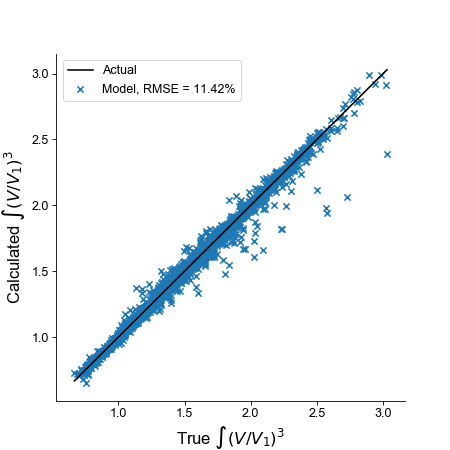

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


 loss  R2 = 0.9870, RMSE = 11.4229, MAE =  5.7632


In [19]:

features_u = ['phi','psi','gc','tc','tec','DH']
V3real = data['V3_V1'].to_numpy()


Xu = data[features_u].to_numpy()

print(np.shape(Xu))
Xsamp_u = Xu
Xsamp_un = standardise_orig(X_lim_u,Xsamp_u)
print(np.max(Xsamp_un,axis = 0))
print(np.min(Xsamp_un,axis = 0))
u1_pred = unnormalise(yuss1,np.squeeze(uss1_model.get_polyfit(Xsamp_un)))
u2_pred = unnormalise(yuss2,np.squeeze(uss2_model.get_polyfit(Xsamp_un)))
u3_pred = unnormalise(yuss3,np.squeeze(uss3_model.get_polyfit(Xsamp_un)))
u4_pred = unnormalise(yuss4,np.squeeze(uss4_model.get_polyfit(Xsamp_un)))


u_pred = np.concatenate((u1_pred.reshape((-1,1)),u2_pred.reshape((-1,1)), 
                    u3_pred.reshape((-1,1)), u4_pred.reshape((-1,1))),axis=1)


u1_unc = unnormalise(yuss1,predict_uncertainty(uss1_model,Xsamp_un,SigU1,QU1)) - np.min(yuss1)
u2_unc = unnormalise(yuss2,predict_uncertainty(uss2_model,Xsamp_un,SigU2,QU2)) - np.min(yuss2)
u3_unc = unnormalise(yuss3,predict_uncertainty(uss3_model,Xsamp_un,SigU3,QU3)) - np.min(yuss3)
u4_unc = unnormalise(yuss4,predict_uncertainty(uss4_model,Xsamp_un,SigU4,QU4)) - np.min(yuss4)
u_unc = np.concatenate((u1_unc.reshape((-1,1)),u2_unc.reshape((-1,1)), 
                    u3_unc.reshape((-1,1)),u4_unc.reshape((-1,1))),axis=1)
#V_p = u_pred[:,0:3]@VT[0:3,:] + x_mean
V_p = u_pred[:,0:3]@VT[0:3,:] + x_mean
V_un = u_unc[:,0:3]@abs(VT[0:3,:])
fig, ax = plt.subplots(figsize=(6,6))
plt.plot([np.min(V3real),np.max(V3real)],[np.min(V3real),np.max(V3real)],'k',label='Actual') 
V3est = -np.trapz(V_p[:,50:100]**3, x=xc1[50:100].flatten(),axis=1) + np.trapz(V_p[:,0:50]**3, x=xc1[0:50].flatten(),axis=1)
#ax = plt.subplot(4,1,subdim)
RMSE = 100*np.sqrt(np.mean((V3real-V3est)**2))/np.std(V3real)
MAE = 100*np.mean(np.abs(V3real-V3est))/np.std(V3real)
R2  = metrics.r2_score(V3real,V3est)
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSE,MAE))
plt.scatter(V3real, V3est,marker='x',label="Model, RMSE = %.2f"  %(RMSE)+"%") 
plt.xlabel('True $\int{(V/V_{1})^3}$',fontsize=16)
plt.ylabel('Calculated $\int{(V/V_{1})^3}$',fontsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.legend(fontsize=12)
plt.savefig('vcubed.eps')

error_v3 = V3est - V3real
data['error_v3'] = error_v3
#V, isamp,loss,sc,DH,V1_U = predict_V(0.3,0.8,2.2,0.045,0.33)

<IPython.core.display.Javascript object>


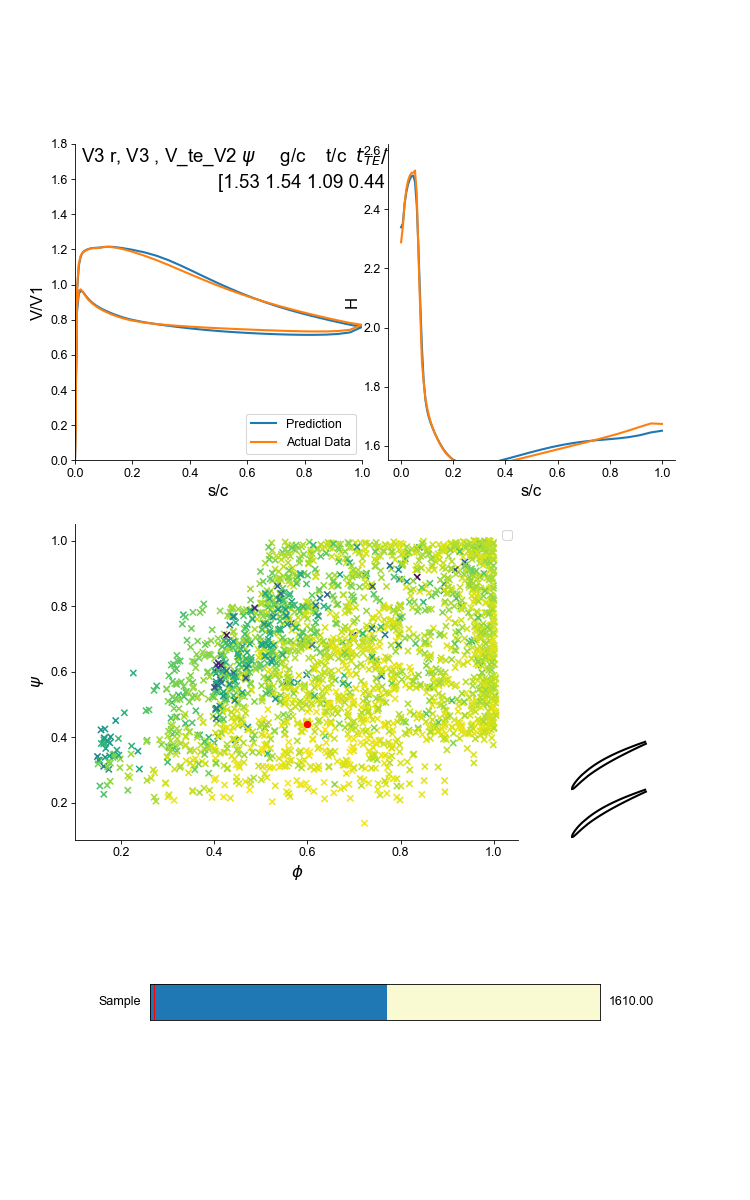

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
No handles with labels found to put in legend.


In [20]:




fig2 = plt.figure(constrained_layout=True,figsize=(10,16))
plt.subplots_adjust(left=0.1, bottom=0.3)
spec2 = gridspec.GridSpec(2, 4, figure=fig2)
ax = fig2.add_subplot(spec2[0, 0:2])



cos_in, cos_out, DH, V1_U = angles(data['phi'],data['psi'])
lost_eff = data['loss']*((V1_U)**2)/data['psi']
eff = 1-lost_eff
isort = np.argsort(data['V3_V1'])
#print(isort)
plt.ylim((0, 1.8))
V_p = u_pred[:,0:3]@VT[0:3,:] + x_mean
V_un = u_unc[:,0:3]@abs(VT[0:3,:])
ind1 = 26
ind = isort[ind1]
V = V_p[ind,:]
Vt = Xo[ind,:]

H_sst = H_ss[ind,:]

V1 = data['V1'][ind]
H = data['Hb_te'][ind]
phi = Xu[ind,0]
psi = Xu[ind,1]
gc = Xu[ind,2]
#DH = Xu[ind,5]
tc = Xu[ind,3]
te = Xu[ind,4]/tc
H_ssp = predict_Hss(phi,psi,H,tc,te)
xu,yu,xl,yl,xcam,ycam,thick,chi, schord= gen_blade(data['dcam_le'][ind],data['dcam_te'][ind],data['chi_le'][ind],data['chi_te'][ind],data['tc'][ind],data['te'][ind],xc)
un = np.mean(V_un[ind,:])
ann1 = ax.annotate('V3 r, V3 , V_te_V2 $\psi$     g/c    t/c  $t_{TE}/t$, $\eta$',xy=(0.02,1.7),color = 'k',fontsize=18)
ann = ax.annotate(str(np.round([data['V3_V1'][ind], V3est[ind],data['V_te_V2'][ind],psi,gc,tc,te,eff[ind]],2)),xy=(0.0,1.55),color = 'k',fontsize=18)

l, = plt.plot(xc1, V.T,label='Prediction', lw=2)
l2, = plt.plot(xc1, Vt.T,label='Actual Data', lw=2)
#l8, = plt.plot(xc1, Vd.T,label='Triangle Data', lw=2)
#l9, = plt.plot(xc1, Vmm[ind,:].T,label='Transformed Data', lw=2)
ax.margins(x=0)

ax.set_xlabel('s/c',fontsize=16)
ax.set_ylabel('V/V1',fontsize=16)
ax.legend(loc = 4)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
axcolor = 'lightgoldenrodyellow'

axSamp = plt.axes([0.2, 0.15, 0.6, 0.03], facecolor=axcolor)

sSamp = Slider(axSamp, 'Sample', 0, len(Xu[:,0]), valinit=ind1,valstep=1)
plt.savefig('vel.eps')
ax2 = fig2.add_subplot(spec2[1, 3])

l3,=plt.plot(xu, yu, 'k',lw=2)
l4,=plt.plot(xl, yl, 'k',lw=2)

pitch = data['sc'][ind]*0.028
l5,=plt.plot(xu, yu+pitch, 'k',lw=2)
l6,=plt.plot(xl, yl+pitch, 'k',lw=2)
ax2.set_xlim([-0.001, 0.025])
ax2.set_ylim([-0.001, 0.1])
ax2.set_aspect('equal')
plt.axis('off')



ax4 = fig2.add_subplot(spec2[1, 0:3])
plt.scatter(data['phi'], data['psi'],c=eff,marker='x') 
l7,=plt.plot(data['phi'][ind], data['psi'][ind], c='r',marker='o',lw=3)
plt.xlabel('$\phi$',fontsize=16)
plt.ylabel('$\psi$',fontsize=16)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
plt.legend(fontsize=12)


ax5 = fig2.add_subplot(spec2[0, 2:])

l8, = plt.plot(xc, H_ssp.T,label='Prediction', lw=2)
l9, = plt.plot(xc, H_sst.T,label='Actual Data', lw=2)
#ax5.set_aspect('equal')
ax5.set_xlabel('s/c',fontsize=16)
ax5.set_ylabel('H',fontsize=16)
#ax5.legend(loc = 4)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False) 

def update(val):
    global ann
    
    ind = int(sSamp.val)
    ind = isort[ind]
    phi = Xu[ind,0]
    psi = Xu[ind,1]
    gc = Xu[ind,2]
    #DH = Xu[ind,5]
    tc = Xu[ind,3]
    te = Xu[ind,4]/tc
    V = V_p[ind,:]
    Vt = Xo[ind,:]
    V1 = data['V1'][ind]
    un = np.mean(V_un[ind,:])
    xu,yu,xl,yl,xcam,ycam,thick,chi, schord= gen_blade(data['dcam_le'][ind],data['dcam_te'][ind],data['chi_le'][ind],data['chi_te'][ind],data['tc'][ind],data['te'][ind],xc)
    pitch = data['sc'][ind]*0.028

    H_sst = H_ss[ind,:]

    V1 = data['V1'][ind]
    H = data['Hb_te'][ind]
    H_ssp = predict_Hss(phi,psi,H,tc,te)
    
    l.set_ydata(V.T)
    l2.set_ydata(Vt.T)
    #l8.set_ydata(Vd.T)
    #l9.set_ydata(Vmm[ind,:].T)
    l3.set_ydata(yu)
    l4.set_ydata(yl)
    l3.set_xdata(xu)
    l4.set_xdata(xl)
    l5.set_xdata(xu)
    l6.set_xdata(xl)
    l5.set_ydata(yu+pitch)
    l6.set_ydata(yl+pitch)
    l7.set_xdata(data['phi'][ind])
    l7.set_ydata(data['psi'][ind])
    l8.set_ydata(H_ssp.T)
    l9.set_ydata(H_sst.T)
    ann.remove()
    ann = ax.annotate(str(np.round([data['V3_V1'][ind], V3est[ind], data['V_te_V2'][ind],psi,gc,tc,te,eff[ind]],2)),xy=(0.5,1.55),color = 'k',fontsize=18)
    #plt.scatter(data['phi'][ind], data['psi'][ind],c=data['loss'][ind],marker='o')
    fig.canvas.draw_idle()
    #plt.savefig('vel.eps')


sSamp.on_changed(update)


plt.show()

# Rethinking Design

> A 5D problem can be reparameterised in infinite different ways. The result is we can learn more low order polynomial models to predict the intial design parameters from other parameters used to capture the flow.

> The below example seeks to model phi, psi and t/c from knowing the integral of the velocity cubed, de Haller, the exit area, pitch and trailing edge thickness ratio

> The models may not look fantastic but note they are normalised between the maximum and minimum values. So in case of t/c we are still getting predictions with +-0.01 in the worst case.

 loss  R2 = 0.9964, RMSE = 0.0148, MAE =  0.0109


<IPython.core.display.Javascript object>


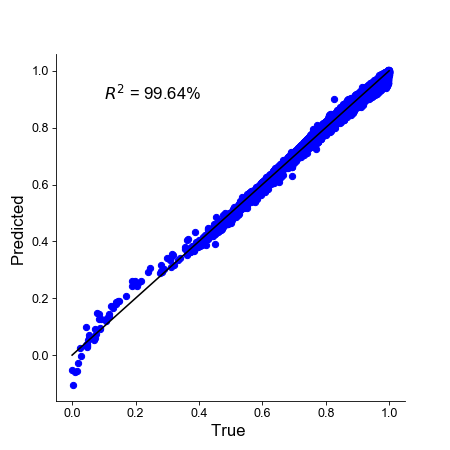

 loss  R2 = 0.9859, RMSE = 0.0286, MAE =  0.0211


<IPython.core.display.Javascript object>


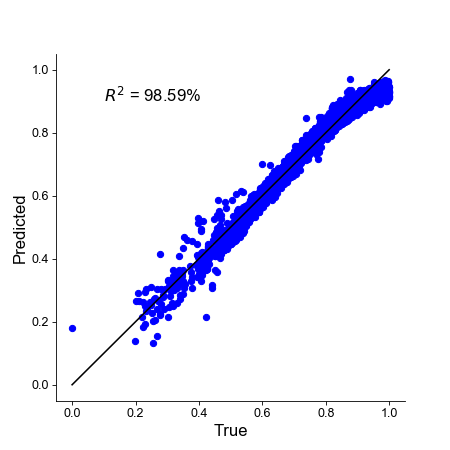

 loss  R2 = 0.9655, RMSE = 0.0630, MAE =  0.0422


<IPython.core.display.Javascript object>


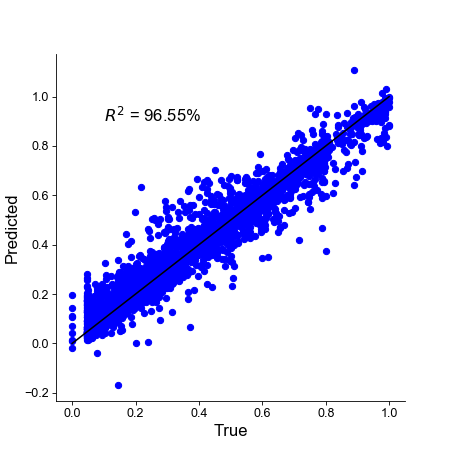

 loss  R2 = 0.9535, RMSE = 0.0362, MAE =  0.0250


<IPython.core.display.Javascript object>


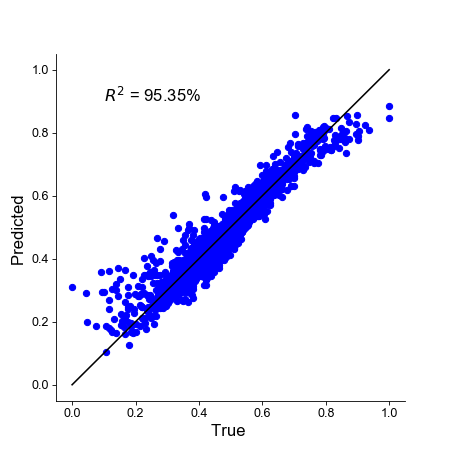

 loss  R2 = 0.7303, RMSE = 0.0264, MAE =  0.0143


<IPython.core.display.Javascript object>


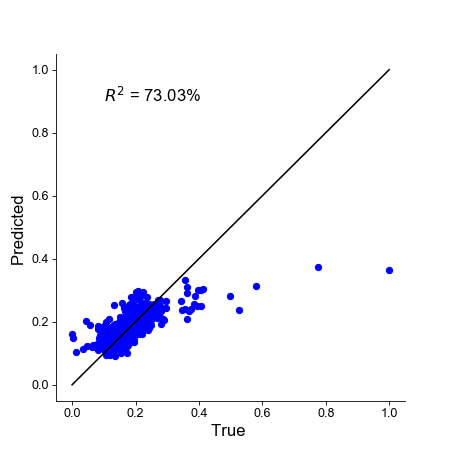

 loss  R2 = 0.9955, RMSE = 0.0131, MAE =  0.0098


<IPython.core.display.Javascript object>


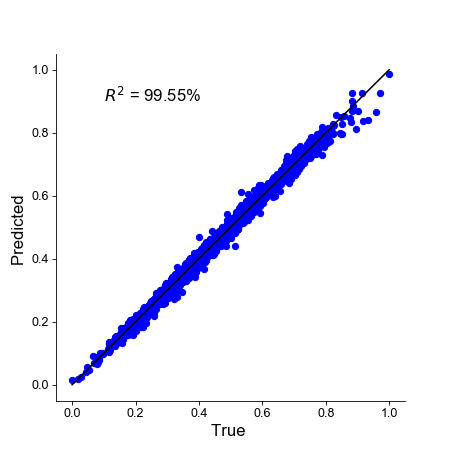

 loss  R2 = 0.9969, RMSE = 0.0132, MAE =  0.0085


<IPython.core.display.Javascript object>


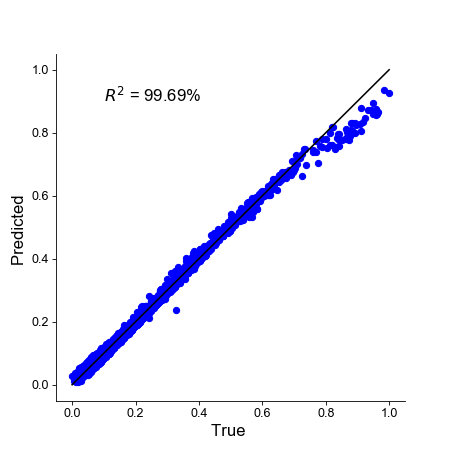

 loss  R2 = 0.9825, RMSE = 0.0484, MAE =  0.0326


<IPython.core.display.Javascript object>


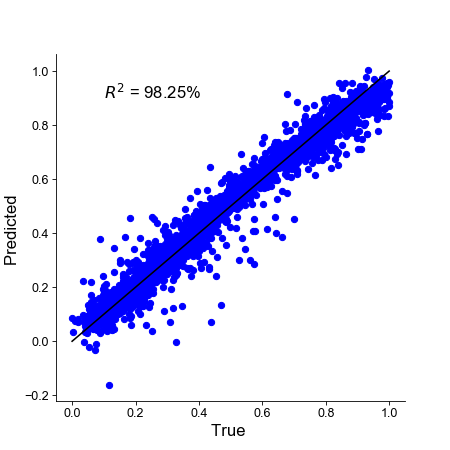

In [28]:
# Reverse design
# Create model for phi, psi as a function of v^3, DH, gc, t tec
features_rev = ['V3_V2','DH','gc2','sc','tec']
features_rev2 = ['V3_V2','DH','gc2','sc','tec']



X_lim_rev = np.vstack((np.max(data[features_rev].to_numpy(), axis=0), 
              np.min(data[features_rev].to_numpy(),axis=0)))


Xrev2 = data[features_rev].to_numpy()

Xrev = np.log(data[features_rev].to_numpy())
logX_lim_rev = np.log(X_lim_rev)
#rangelogX = logX_lim_u[0,:]-logX_lim_u[1,:]
X_lim_rev = np.vstack((np.max(data[features_rev].to_numpy(), axis=0), 
              np.min(data[features_rev].to_numpy(),axis=0)))

nrow, dim = np.shape(Xrev)
Xrevn = standardise_orig(logX_lim_rev ,Xrev)
Xrevn2 = standardise_orig(X_lim_rev ,Xrev2)


yphi = data['phi'].to_numpy()
yphi = np.log(data['phi'].to_numpy())
ynormphi = normalise(yphi)
ypsi = data['psi'].to_numpy()
ypsi = np.log(data['psi'].to_numpy())
ynormpsi = normalise(ypsi)
ytc = data['tc'].to_numpy()
#ytc = np.log(data['tc'].to_numpy())
ynormtc = normalise(ytc)



# Create a polynomial as before
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
phi_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xrevn, 'sample-outputs': ynormphi})
phi_model.set_model()
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [srev for _ in range(0, dim)]
psi_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xrevn, 'sample-outputs': ynormpsi})
psi_model.set_model()


srev = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [srev for _ in range(0, dim)]
tc_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xrevn2, 'sample-outputs': ynormtc})
tc_model.set_model()

ypred = np.squeeze(phi_model.get_polyfit(Xrevn)) 
ynorm = ynormphi
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('$\phi$ model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('phi.eps')

ypred = np.squeeze(psi_model.get_polyfit(Xrevn)) 
ynorm = ynormpsi
RMSEU2 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU2,MAE))
fig2 = plt.figure('$\psi$ model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True',fontsize=16)
ax2.set_ylabel('Predicted',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('psi.eps')


ypred = np.squeeze(tc_model.get_polyfit(Xrevn2)) 
ynorm = ynormtc
RMSEU2 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU2,MAE))
fig2 = plt.figure('tc model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')

ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True',fontsize=16)
ax2.set_ylabel('Predicted',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()
plt.savefig('psi.eps')

def reverse_design_V3(V3,DH,gc,sc, te):
    global yphi, ypsi,ytc, logX_lim_rev, X_lim_rev
    Xsamp_rev2 =np.concatenate((np.array(V3).reshape((-1,1)),np.array(DH).reshape((-1,1)), 
                    np.array(gc).reshape((-1,1)),np.array(sc).reshape((-1,1)),np.array(te).reshape((-1,1))),axis=1)
    Xsamp_revn2 = standardise_orig(X_lim_rev,Xsamp_rev2)
    Xsamp_rev  = np.log(Xsamp_rev2)
    Xsamp_revn = standardise_orig(logX_lim_rev,Xsamp_rev)
    
    phi = np.exp(unnormalise(yphi,np.squeeze(phi_model.get_polyfit(Xsamp_revn))))
    psi = np.exp(unnormalise(ypsi,np.squeeze(psi_model.get_polyfit(Xsamp_revn))))
    tc = unnormalise(ytc,np.squeeze(tc_model.get_polyfit(Xsamp_revn2)))
    #print(np.squeeze(tc_model.get_polyfit(Xsamp_revn2)))
    return phi,psi, tc



def sample_smithV3(V3,DH,gc,cos_in,tec,N):

    # Creat subset of data for thin aerofoil analysis
    nsamp = N*N
    cos_out = cos_in/DH
    cos_max = cos_out +0.05
    cos_min = cos_out -0.2
    DH_min  = DH - 0.05
    DH_max = DH +0.05
    # Sample test input parameters for the search space
    max_min = np.array([[V3, DH_max, gc, cos_max,tec],
              [V3, DH_min,gc,  cos_min,tec]])

    dim = 5
    Xsamples = np.random.rand(nsamp,dim)
    for i in range(0,dim):
        max_X = max_min[0,i]
        min_X = max_min[1,i]
        range_X =  max_X - min_X
        Xsamples[:,i] =  range_X*Xsamples[:,i] + min_X

    #print(Xsamples)
    #Conversion to te/c from te/t    
    #Xsamples[:,4] = Xsamples[:,3]*Xsamples[:,4]
    DH_samples = np.linspace(max_min[1,1], max_min[0,1], N)
    CO_samples = np.linspace(max_min[1,3], max_min[0,3], N)
    [DH, CO] = np.meshgrid(DH_samples, CO_samples)
    DH_vec = np.reshape(DH, (N*N, 1))
    CO_vec = np.reshape(CO, (N*N, 1)) 
    Xsamples[:,1] = DH_vec.flatten()
    Xsamples[:,3] = CO_vec.flatten()
    
    PHI_vec = np.zeros(np.shape(Xsamples[:,0]))
    PSI_vec = np.zeros(np.shape(Xsamples[:,0]))
    V1_U = np.zeros(np.shape(Xsamples[:,0]))
    tc = np.zeros(np.shape(Xsamples[:,0]))
    Hs = np.zeros(np.shape(Xsamples[:,0]))
    loss = np.zeros(np.shape(Xsamples[:,0]))
    # overwirting for structured smith chart
    for i in range(0,nsamp):
        V3s  = Xsamples[i,0]
        tecs = Xsamples[i,4]
        DHs  = Xsamples[i,1]
        gc2s = Xsamples[i,2]
        cos_outs = Xsamples[i,3]
        sc = gc2s/(cos_outs)
        phi, psi, tcs = reverse_design_V3(V3s,DHs,gc2s,sc,tecs )
        te = tecs/tcs
        gcs = gc2s*DHs
        V, isamp,loss[i],sc,DH,V1_Us, V_un,V3est = predict_V_gc(phi,psi,gcs,tcs,te)
        H = get_H(phi,psi,gcs,tcs,tecs)

        PHI_vec[i] = phi
        PSI_vec[i] = psi
        V1_U[i] = V1_Us
        tc[i]=tcs
        Hs[i]=H
    
    V3  = Xsamples[:,0]
    tec = Xsamples[:,4]
    DH  = Xsamples[:,1]
    gc2 = Xsamples[:,2]
    cos_out = Xsamples[:,3]
    sc = gc2*DH/cos_in
    cos_in = cos_out*DH
    lost_eff = loss*((V1_U)**2)/PSI_vec
    eff = 1-lost_eff
    return loss, lost_eff, PHI_vec, PSI_vec, DH,V1_U,sc,gc2, cos_in, cos_out,Hs,tc

def sample_smith_loss(loss,gc2,tec,N):

    # Creat subset of data for thin aerofoil analysis
    nsamp = N*N
    # Sample test input parameters for the search space
    max_min = np.array([[1.0, 1.0, loss, gc2,tec],
              [0.3, 0.3,loss,  gc2,tec]])

    dim = 5
    Xsamples = np.random.rand(nsamp,dim)
    for i in range(0,dim):
        max_X = max_min[0,i]
        min_X = max_min[1,i]
        range_X =  max_X - min_X
        Xsamples[:,i] =  range_X*Xsamples[:,i] + min_X

    #print(Xsamples)
    #Conversion to te/c from te/t    
    #Xsamples[:,4] = Xsamples[:,3]*Xsamples[:,4]

    # overwirting for structured smith chart
    phi_samples = np.linspace(max_min[1,0], max_min[0,0], N)
    psi_samples = np.linspace(max_min[1,1], max_min[0,1], N)
    [PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
    PHI_vec = np.reshape(PHI, (N*N, 1))
    PSI_vec = np.reshape(PSI, (N*N, 1)) 
    Xsamples[:,0] = PHI_vec.flatten()
    Xsamples[:,1] = PSI_vec.flatten()
    [cos_in, cos_out, DH, V1_U]= angles(Xsamples[:,0],Xsamples[:,1])
    
    loss2 = loss/DH**2
    #V32 = V3/(DH**3)
    gc2   = Xsamples[:,3] 
    tec   = Xsamples[:,4] 
    gc    = gc2*DH
    sc = gc/cos_in
    V3 = (loss2*(gc2**0.89)/(0.0042))**0.78
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    V3 = (loss2+0.0439 - 0.00476*V3/gc2)/0.01167
    
    phi, psi, tc = reverse_design_V3(V3,DH,gc,sc,tec )
    phi = Xsamples[:,0]
    psi = Xsamples[:,1]
    te = tec/tc
    V_p, isamp, loss,sc, DH, V1_U,V_un, V3est = predict_V_gc(phi,psi,gc,tc,te)
    av_un =np.mean(V_un,axis=1)
    
    mask = np.zeros(np.shape(phi))
    mask[np.where((av_un >3))] = 1
    [cos_in, cos_out, DH, V1_U]=angles(phi,psi)
    gc2 = gc/DH
    rho = 417/(V1_U*68.05)
    lost_eff = loss*((V1_U)**2)/Xsamples[:,1]
    eff = 1-lost_eff
    return loss, lost_eff, phi, psi, DH,V1_U,sc,gc,gc2, cos_in, cos_out,tc,mask,V3*DH**3



# Create model for phi, psi as a function of v^3, DH, gc, t tec
features_geo = ['phi','psi','gc','tc','tec']




X_lim_geo = np.vstack((np.max(data[features_geo].to_numpy(), axis=0), 
              np.min(data[features_geo].to_numpy(),axis=0)))


Xgeo2 = data[features_geo].to_numpy()

Xgeo = np.log(data[features_geo].to_numpy())
logX_lim_geo = np.log(X_lim_geo)

X_lim_geo = np.vstack((np.max(data[features_geo].to_numpy(), axis=0), 
              np.min(data[features_geo].to_numpy(),axis=0)))

nrow, dim = np.shape(Xgeo)
Xgeon = standardise_orig(logX_lim_geo ,Xgeo)
Xgeon2 = standardise_orig(X_lim_geo ,Xgeo2)


ydcamle = data['dcam_le'].to_numpy()
#ydcamle = np.log(data['dcam_le'].to_numpy())
ynormdcamle = normalise(ydcamle)

ydcamte = data['dcam_te'].to_numpy()
#ydcamte = np.log(data['dcam_te'].to_numpy())
ynormdcamte = normalise(ydcamte)

ychile = data['chi_le'].to_numpy()
#ychile = np.log(data['chi_le'].to_numpy())
ynormchile = normalise(ychile)

ychite = data['chi_te'].to_numpy()
#ychite = np.log(data['chi_te'].to_numpy())
ynormchite = normalise(ychite)

# Create a polynomial as before
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
dcam_le_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xgeon2, 'sample-outputs': ynormdcamle})
dcam_le_model.set_model()



# dcam le
ypred = np.squeeze(dcam_le_model.get_polyfit(Xgeon2)) 
ynorm = ynormdcamle
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('dcam_{le} model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')
ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()


# dcam te
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=4)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
dcam_te_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xgeon2, 'sample-outputs': ynormdcamte})
dcam_te_model.set_model()

ypred = np.squeeze(dcam_te_model.get_polyfit(Xgeon2)) 
ynorm = ynormdcamte
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('dcam_{te} model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')
ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()



# chi le
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=3)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
chi_le_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xgeon2, 'sample-outputs': ynormchile})
chi_le_model.set_model()

ypred = np.squeeze(chi_le_model.get_polyfit(Xgeon2)) 
ynorm = ynormchile
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('chi_{le} model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')
ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()



# chi te
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=2)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
chi_te_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xgeon2, 'sample-outputs': ynormchite})
chi_te_model.set_model()

ypred = np.squeeze(chi_te_model.get_polyfit(Xgeon2)) 
ynorm = ynormchite
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('chi_{te} model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')
ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()



def create_geom(phi,psi,gc,tc, te):
    global ydcamle, ydcamte,ychile, ychite, X_lim_geo
    Xsamp_rev2 = np.array([phi,psi,gc,tc,te]).reshape((1,-1))
    Xsamp_revn2 = standardise_orig(X_lim_geo,Xsamp_rev2)
    dcam_le = unnormalise(ydcamle,np.squeeze(dcam_le_model.get_polyfit(Xsamp_revn2)))
    dcam_te = unnormalise(ydcamte,np.squeeze(dcam_te_model.get_polyfit(Xsamp_revn2)))
    chi_le = unnormalise(ychile,np.squeeze(chi_le_model.get_polyfit(Xsamp_revn2)))
    chi_te = unnormalise(ychite,np.squeeze(chi_te_model.get_polyfit(Xsamp_revn2)))
    
    return dcam_le, dcam_te, chi_le, chi_te


yH = data['Hb_te'].to_numpy()
#ychite = np.log(data['chi_te'].to_numpy())
ynormH = normalise(yH)

# Create a polynomial as before
srev = Parameter(distribution='uniform', lower=-1., upper=1., order=4)
myparametersu = [srev for _ in range(0, dim)]

mybasis1 = Basis('total-order')
H_model = Poly(parameters=myparametersu, basis=mybasis1, method='least-squares', \
              sampling_args= {'mesh': 'user-defined', 'sample-points': Xgeon2, 'sample-outputs': ynormH})
H_model.set_model()



# dcam le
ypred = np.squeeze(H_model.get_polyfit(Xgeon2)) 
ynorm = ynormH
RMSEU1 = np.sqrt(np.mean((ynorm-ypred)**2))#/np.std(ytest)
MAE = np.mean(np.abs(ynorm-ypred))#/np.std(ytest)
R2 = linregress(ynorm, ypred)[2]
print(" loss  R2 = %.4f, RMSE = %.4f, MAE =  %.4f" %(R2,RMSEU1,MAE))
fig2 = plt.figure('H model',figsize=(6,6))
ax2 = fig2.add_subplot(111)
ax2.plot(ynorm,ypred,'bo')
ax2.plot([np.min(ynorm),np.max(ynorm)],[np.min(ynorm),np.max(ynorm)],'k-')
ann1 = ax2.annotate('$R^2$ = '+str(np.round(R2*100,2))+'%',xy=(0.1,0.9),color = 'k',fontsize=16)
ax2.set_xlabel('True ',fontsize=16)
ax2.set_ylabel('Predicted ',fontsize=16)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
plt.show()


def get_H(phi,psi,gc,tc, te):
    global yH, X_lim_geo
    Xsamp_rev2 = np.array([phi,psi,gc,tc,te]).reshape((1,-1))
    Xsamp_revn2 = standardise_orig(X_lim_geo,Xsamp_rev2)
    H = unnormalise(yH,np.squeeze(H_model.get_polyfit(Xsamp_revn2)))
    return H

def loss_breakdown(cos_out,sc,tec,V3est,H23,Vte_V2,Cd,phi,psi,H,tc):
    mix_loss = (Vte_V2-1)**2
    ref = Vte_V2**2
    sol = (1/sc)
    bl  = 4*Cd*H23*V3est/(Vte_V2**3)
    base = 0.11*tec
    
    base_loss = ref*sol*base/cos_out
    bl_loss = ref*sol*bl/cos_out
    
    loss_tot = bl_loss+base_loss+mix_loss
    
    
    # Sample test input parameters for the search space
    te_max = (tec*1.01)/tc
    te_min = (tec*0.99)/tc
    dtec = 0.02*tec
    Xsamples = np.array([[phi, psi, H, tc,te_max],
              [phi, psi,H,  tc,te_min]])

    
    Vs, isamp, loss,scs, DHs, V1_Us,V_un, V3ests, H23s,Cds = predict_V(Xsamples[:,0],Xsamples[:,1],Xsamples[:,2],Xsamples[:,3],Xsamples[:,4])
    [cos_ins, cos_outs, DHs, V1_Us]=angles(Xsamples[:,0],Xsamples[:,1])
    gcs = scs*cos_ins
    gc2 = gcs/DHs
    Vtes = Vs[:,49]
    Vte_V2s = Vtes/DHs
    V3est2s = V3ests/(DHs**3)
    
    # Get derivatives
    dmix = ((Vte_V2s[0]-1)**2 - (Vte_V2s[1]-1)**2)/dtec
    dref = (((Vte_V2s[0])**2 - (Vte_V2s[1])**2)/dtec)*sol*(bl+base)/cos_out
    dsol = (((1/scs[0]) - (1/scs[1]))/dtec)*ref*(bl+base)/cos_out
    dbl  = 4*((Cds[0]*H23s[0]*V3est2s[0]/(Vte_V2s[0]**3) - Cds[1]*H23s[1]*V3est2s[1]/(Vte_V2s[1]**3))/dtec)*ref*sol/cos_out
    dbase = 0.11*ref*sol/cos_out
    
    return loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase


def sample_TE(phi,psi,tc,N,AR,ec):

    # Creat subset of data for thin aerofoil analysis
    nsamp = N*N
    # Sample test input parameters for the search space
    max_min = np.array([[phi, psi, 1.9, tc,0.7],
              [phi, psi,1.6,  tc,0.05]])

    dim = 5
    Xsamples = np.random.rand(nsamp,dim)
    for i in range(0,dim):
        max_X = max_min[0,i]
        min_X = max_min[1,i]
        range_X =  max_X - min_X
        Xsamples[:,i] =  range_X*Xsamples[:,i] + min_X

    #print(Xsamples)
    #Conversion to te/c from te/t    
    #Xsamples[:,4] = Xsamples[:,3]*Xsamples[:,4]

    # overwirting for structured smith chart
    phi_samples = np.linspace(max_min[1,2], max_min[0,2], N)
    psi_samples = np.linspace(max_min[1,4], max_min[0,4], N)
    [H, te] = np.meshgrid(phi_samples, psi_samples)
    H_vec = np.reshape(H, (N*N, 1))
    te_vec = np.reshape(te, (N*N, 1)) 
    Xsamples[:,2] = H_vec.flatten()
    Xsamples[:,4] = te_vec.flatten()
    #loss = np.zeros(np.shape(Xsamples[:,0]))
   # DH = np.zeros(np.shape(Xsamples[:,0]))
    #sc = np.zeros(np.shape(Xsamples[:,0]))
   # V1_U = np.zeros(np.shape(Xsamples[:,0]))
    print(np.shape(Xsamples[:,0]))
    V_p, isamp, loss,sc, DH, V1_U,V_un, V3est, H23,Cd = predict_V(Xsamples[:,0],Xsamples[:,1],Xsamples[:,2],Xsamples[:,3],Xsamples[:,4])
    #for i in range(0,nsamp):
    #    V_p, isamp, loss[i],sc[i], DH[i], V1_U[i],V_un, V3est = predict_V(Xsamples[i,0],Xsamples[i,1],Xsamples[i,2],Xsamples[i,3],Xsamples[i,4])
    #loss,sc,DH,V1_U,loss_err= predict_loss(Xsamples[:,0],Xsamples[:,1],Xsamples[:,2],Xsamples[:,3],Xsamples[:,4])
    [cos_in, cos_out, DH, V1_U]=angles(Xsamples[:,0],Xsamples[:,1])
    gc = sc*cos_in
    #V_p, isamp, loss,sc, DH, V1_U,V_un = predict_V_gc(Xsamples[:,0],Xsamples[:,1],gc,Xsamples[:,3],Xsamples[:,4])
    EC = ec*np.ones((N*N,1 ))
    [cos_in, cos_out, DH, V1_U, sc,DF] = parameters(Xsamples[:,0],Xsamples[:,1],gc,Xsamples[:,3])
    beta = np.array([0.06925694,
            -0.78955089,
    4.79552054,
    -11.28834548,
    9.36594389,
    63.42547887,
    -614.56718287,
    2204.62301995,
    -3470.72680381,
    2034.16092926,
    -1479.23330237,
    12818.31717717,
    -38223.81950502,
    43618.99593009,
    -12516.48005119,
    4165.78162138,
    -20645.77804574,
    -18322.84464532,
    216305.10857349,
    -266162.66625881])
    #D = np.array([1, DF, DF**2, DF**3, DF**4, EC, EC*DF, EC*DF**2, EC*DF**3, EC*DF**4,EC**2,(EC**2)*DF,
    #     (EC**2)*DF**2, (EC**2)*DF**3, (EC**2)*DF**4, (EC**3), (EC**3)*DF, (EC**3)*DF**2, (EC**3)*DF**3, (EC**3)*DF**4])
    DF2 = DF.reshape((-1,1))
    
    D = np.concatenate((np.ones((N*N,1 )), DF2, DF2**2, DF2**3, DF2**4, EC, EC*DF2, EC*DF2**2, EC*DF2**3, EC*DF2**4,EC**2,(EC**2)*DF2,
         (EC**2)*DF2**2, (EC**2)*DF2**3, (EC**2)*DF2**4, (EC**3), (EC**3)*DF2, (EC**3)*DF2**2, (EC**3)*DF2**3, (EC**3)*DF2**4), axis = 1)
    ELP = D@beta.reshape((-1,1))
    print(np.shape(D), np.shape(ELP),np.shape(beta))
    loss_ew = ((ELP.reshape((-1,))*DH**2)/AR).reshape((-1,))
    rho = 417/(V1_U*68.05)
    loss_tot = loss+loss_ew
    lost_eff = loss_tot*((V1_U)**2)/Xsamples[:,1]
    
    eff = 1-lost_eff
    return loss, lost_eff, H_vec, te_vec, DH,V1_U,sc,gc, cos_in, cos_out,  H23,Cd,V3est

# **Dynamic Learning**


> With all these models in place it is possible to explore the entire design space in any desired manner, that is rapidly test new hypotheses and ideas. Rather than knowing what to look for when setting up an experiment, the models can be used to sample from the full space and fix and vary parameters as desired. This provides the possibility for quick dynamic learning as shown below.# Smith chart analysis

<IPython.core.display.Javascript object>


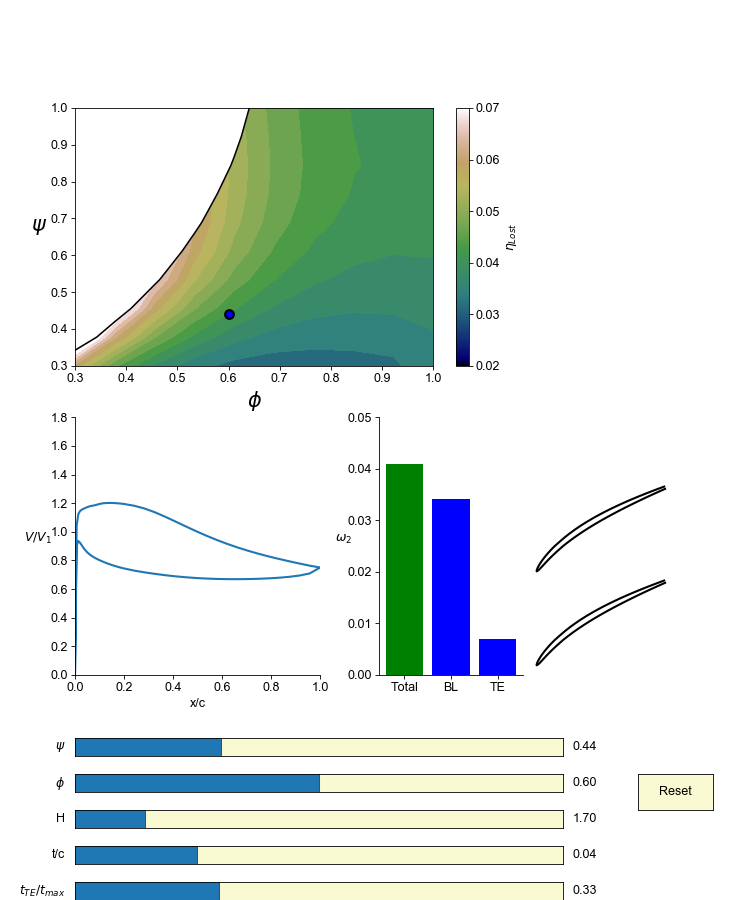

(100,)
(100, 20) (100, 1) (20,)


In [22]:
# Smith chart analysis

fig2 = plt.figure(constrained_layout=True,figsize=(10,12))
plt.subplots_adjust(left=0.1, bottom=0.25)
spec2 = gridspec.GridSpec(2, 12, figure=fig2)
ax = fig2.add_subplot(spec2[1, 0:5])
plt.ylim((0, 1.8))
tc = 0.04
te = 0.33
tec = tc*te
H = 1.7
phi = 0.6
psi = 0.44
V, isamp,loss,sc,DH,V1_U,V_un, V3est, H23,Cd = predict_V(phi,psi,H,tc,te)
Vte = V[0,49]
Vte_V2 = Vte/DH
V3est2 = V3est/(DH**3)
cos_in, cos_out, DH, V1_U = angles(0.6,0.44)

gc = sc*cos_in
loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase = loss_breakdown(cos_out,sc,tec,V3est2,H23,Vte_V2,Cd,phi,psi,H,tc)
dtot = dmix+dref+dsol+dbl+dbase

lost_eff = loss*((V1_U)**2)/0.44
av_un = np.mean(V_un)
#ann1 = ax.annotate('loss2, phi , psi , s/c , DH , $\eta$ ,  in,  out, te/c, un',xy=(0.12,1.7),color = 'r',fontsize=18)
#ann = ax.annotate(str(np.round([loss*100/(DH**2), phi,psi,sc,DH,lost_eff*100, cos_in, cos_out,100*tec, av_un],2)),xy=(0.1,1.6),color = 'k',fontsize=18)
Vle = 0.98 +0.5*tc*(0.6/0.44)/sc
Vte = DH*(1 - tec/(sc*cos_out))
Vte = V[0,49]
#Vd = v_dickens(Vle,Vte,sc, cos_in, cos_out,np.array(0.44),np.array(0.6))
l5, = plt.plot(xc1, V.T, lw=2)
#l6, = plt.plot(xc1, Vd.T, lw=2)
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.set_xlabel('x/c')
ax.set_ylabel('$V/V_{1}$',rotation=0)
ax.yaxis.set_label_coords(-0.15,0.5)


axcolor = 'lightgoldenrodyellow'
axte = plt.axes([0.1, 0.0, 0.65, 0.02], facecolor=axcolor)
axtc = plt.axes([0.1, 0.04, 0.65, 0.02], facecolor=axcolor)
axH = plt.axes([0.1, 0.08, 0.65, 0.02], facecolor=axcolor)
axphi = plt.axes([0.1, 0.12, 0.65, 0.02], facecolor=axcolor)
axpsi = plt.axes([0.1, 0.16, 0.65, 0.02], facecolor=axcolor)

stc = Slider(axtc, 't/c', 0.02, 0.1, valinit=tc, valstep=0.005)
sH = Slider(axH, 'H', 1.6, 2.3, valinit=H, valstep=0.02)
sphi = Slider(axphi, '$\phi$', 0.2, 1.0, valinit=phi, valstep=0.02)
spsi = Slider(axpsi, '$\psi$', 0.2, 1.0, valinit=psi,valstep=0.02)
ste = Slider(axte, '$t_{TE}/t_{max}$', 0.05, 1.0, valinit=te, valstep=0.001)

ax2 = fig2.add_subplot(spec2[0:2, 9:13])
dcam_le, dcam_te, chi_le, chi_te = create_geom(phi,psi,gc,tc, tec)
xu,yu,xl,yl,xcam,ycam,thick,chi,schord= gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc)
pitch = sc*0.028
l, = plt.plot(xu, yu,'k', lw=2)
l2, = plt.plot(xl, yl,'k', lw=2)
l3, = plt.plot(xu, yu+pitch,'k', lw=2)
l4, = plt.plot(xl, yl+pitch,'k', lw=2)
ax2.margins(x=0)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim([-0.001, 0.025])
ax2.set_ylim([-0.001, 0.1])
ax2.set_aspect('equal')
plt.axis('off')


N = 10
ax3 = fig2.add_subplot(spec2[0, 0:9])

loss, lost_eff, PHI, PSI, DH,V1_U,sc,gc, cos_in, cos_out, H23,Cd,V3 = sample_smith(H,tc,te,N,3.5,0.00)
lost_eff2 =loss.flatten()*((V1_U.flatten())**2)/PSI.flatten()

dc = sc*np.sin(np.arccos(cos_in))
ge  = sc*cos_out
mix = ge/(gc**0.5)
DF = 1 - DH + 0.5*sc.flatten()*PSI.flatten()/V1_U.flatten()

norm =  matplotlib.colors.Normalize(vmin=0.02,vmax=0.07)

surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(lost_eff2,(N,N)),levels=40,norm=norm,cmap=cm.gist_earth)
surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
ax3.set_xlabel('$\phi$',fontsize=20)
h=ax3.set_ylabel('$\psi$',fontsize=20,rotation=0)
fig2.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.gist_earth), ax=ax3, label = '$\eta_{Lost}$')   
ax3.yaxis.set_label_coords(-0.1,0.5)

ax4 = fig2.add_subplot(spec2[1, 6:9])
parts =['Total','BL','TE']
ax4.set_ylabel('$\omega_{2}$',rotation=0)
h1 = plt.bar(parts,[loss_tot,bl_loss,mix_loss+base_loss],color=['Green', 'blue', 'blue'])
ax4.set_ylim([0, 0.05])
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False) 
plt.show()



def update(val):
    global ann, surf, ax3,h1,ax4
    phi = sphi.val
    psi = spsi.val
    H   = sH.val
    tc = stc.val
    te = ste.val
    tec = te*tc
    V, isamp,lossp,sc,DH,V1_U,V_un,V3est,  H23,Cd = predict_V(phi,psi,H,tc,te)
    cos_in, cos_out, DH, V1_U = angles(phi,psi)
    gc = sc*cos_in
    lost_effp = lossp*((V1_U)**2)/psi   
    dcam_le, dcam_te, chi_le, chi_te = create_geom(phi,psi,gc,tc, tec)
    xu,yu,xl,yl,xcam,ycam,thick,chi,schord= gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc)
    Vle = 0.98 +0.5*tc*(phi/psi)/sc
    Vte = V[0,49]
    Vte_V2 = Vte/DH
    V3est2 = V3est/(DH**3)
    loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase = loss_breakdown(cos_out,sc,tec,V3est2,H23,Vte_V2,Cd,phi,psi,H,tc)
    dtot = dmix+dref+dsol+dbl+dbase
    
    #Vd = v_dickens(Vle,Vte,sc, cos_in, cos_out,psi,phi)
    av_un = np.mean(V_un)
    pitch = sc*0.028
    l.set_ydata(yu)
    l2.set_ydata(yl)
    l3.set_ydata(yu+pitch)
    l4.set_ydata(yl+pitch)
    
    l.set_xdata(xu)
    l2.set_xdata(xl)
    l3.set_xdata(xu)
    l4.set_xdata(xl)
    l5.set_ydata(V.T)

    for rect, h in zip(h1, [loss_tot,bl_loss,mix_loss+base_loss]):
        rect.set_height(h)
        
    #for rect, h in zip(h2, [dtot/100,dmix/100,dbl/100,dbase/100, dsol/100,dref/100]):
    #    rect.set_height(h)   
    #l6.set_ydata(Vd.T)
    #ann.remove()
    #ann = ax.annotate(str(np.round([lossp*100/(DH**2), phi,psi,sc,DH,lost_effp*100, cos_in, cos_out,100*tec, av_un],2)),xy=(0.1,1.6),color = 'k',fontsize=18)
    for coll in surf.collections:
        coll.remove()
    
    loss, lost_eff, PHI, PSI, DH,V1_U,sc,gc, cos_in, cos_out, H23,Cd, V3 = sample_smith(H,tc,te,N,3.5,0.00)
    lost_eff2 =loss.flatten()*((V1_U.flatten())**2)/PSI.flatten()
    dc = sc*np.sin(np.arccos(cos_in))
    ge  = sc*cos_out
    mix = ge/(gc**0.5)
    DF = 1 - DH + 0.5*sc.flatten()*PSI.flatten()/V1_U.flatten()
    surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(lost_eff2,(N,N)),levels=40,norm=norm,cmap=cm.gist_earth)
    surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
    surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
    ax3.scatter(phi, psi,  s=70, c='b', marker='o',edgecolors='k',linewidths=2)
    fig2.canvas.draw_idle()
    

    
    
sphi.on_changed(update)
spsi.on_changed(update)
sH.on_changed(update)
stc.on_changed(update)
ste.on_changed(update)

resetax = plt.axes([0.85, 0.1, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sphi.reset()
    spsi.reset()
    sH.reset()
    
    
button.on_clicked(reset)

plt.show()
plt.savefig('highte.png')

<IPython.core.display.Javascript object>


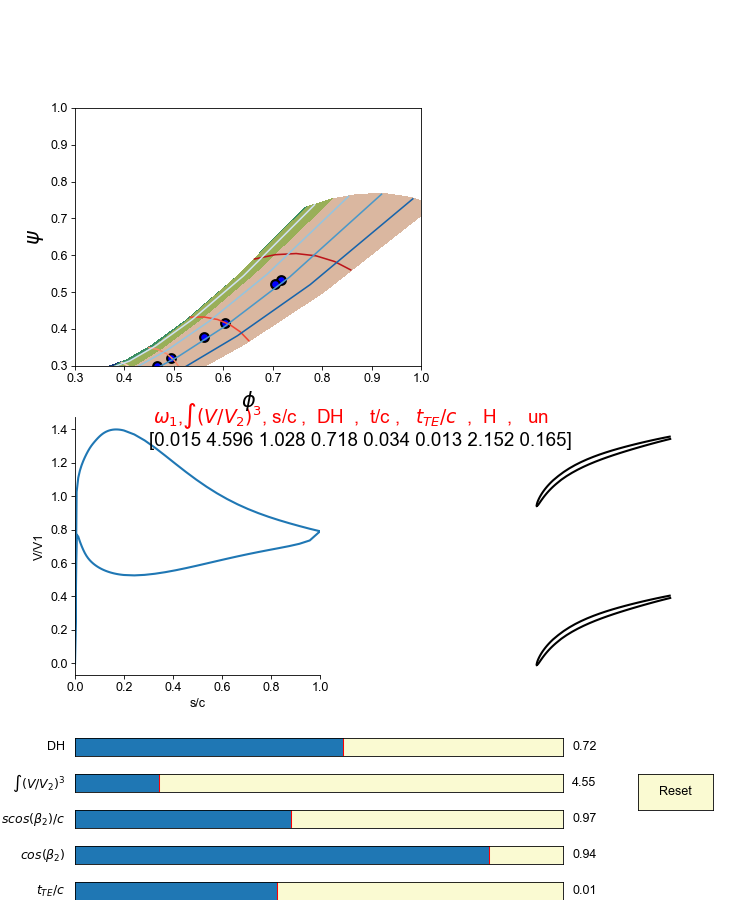

In [25]:
# v3 chart analysis

fig2 = plt.figure(constrained_layout=True,figsize=(10,12))
plt.subplots_adjust(left=0.1, bottom=0.25)
spec2 = gridspec.GridSpec(2, 12, figure=fig2)
ax = fig2.add_subplot(spec2[1, 0:5])
V3 = 4.55
DH = 0.72

gc = np.array(0.7)
cos_out = 0.944
cos_in = DH*cos_out
tec = 0.013
sc = gc/cos_in
gc2 = gc/DH
phi, psi, tc = reverse_design_V3(V3,DH,gc2,sc, tec)
te = tec/tc

V, isamp,loss,sc,DH,V1_U, V_un,V3est = predict_V_gc(phi,psi,gc,tc,te)
lost_effp = loss*((V1_U)**2)/psi 
Vte_V2 = V[0,49]/DH

V3est2 = V3est/(DH**3)
av_un = np.mean(V_un)
H = get_H(phi,psi,gc,tc,tec)
a, b,c,d,e,f,g, m, H23,Cd = predict_V(phi,psi,H,tc,te)
loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase = loss_breakdown(cos_out,sc,tec,V3est2,H23,Vte_V2,Cd,phi,psi,H,tc)


ann1 = ax.annotate('$\omega_{1}$,$\int{(V/V_{2})^{3}}$, s/c ,  DH  ,  t/c ,   $t_{TE}/c$  ,  H  ,   un',xy=(0.32,1.44),color = 'r',fontsize=18)
ann = ax.annotate(str(np.round([loss, V3est2[0],sc,DH,tc, tec, H, av_un],3)),xy=(0.3,1.3),color = 'k',fontsize=18)

l5, = plt.plot(xc1, V.T, lw=2)
#l2, = plt.plot(xc1, Vrecon.T, lw=2)
ax.margins(x=0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 
ax.set_xlabel('s/c')
ax.set_ylabel('V/V1')


axcolor = 'lightgoldenrodyellow'
av_un = np.mean(V_un)
axte = plt.axes([0.1, 0.0, 0.65, 0.02], facecolor=axcolor)
axci = plt.axes([0.1, 0.04, 0.65, 0.02], facecolor=axcolor)
axgc = plt.axes([0.1, 0.08, 0.65, 0.02], facecolor=axcolor)
axV3 = plt.axes([0.1, 0.12, 0.65, 0.02], facecolor=axcolor)
axDH = plt.axes([0.1, 0.16, 0.65, 0.02], facecolor=axcolor)

ste = Slider(axte, '$t_{TE}/c$', 0.001, 0.030, valinit=tec, valstep=0.001)
sci = Slider(axci, '$cos(\\beta_{2})$', 0.6, 1.0, valinit=cos_out, valstep=0.02)
sgc = Slider(axgc, '$scos(\\beta_{2})/c$', 0.15, 2.0, valinit=gc2, valstep=0.02)
sV3 = Slider(axV3, '$\int{(V/V_{2})^{3}}$', 3.0,12.0, valinit=V3, valstep=0.05)
sDH = Slider(axDH, 'DH', 0.5, 0.9, valinit=DH,valstep=0.02)

ax2 = fig2.add_subplot(spec2[0:2, 9:13])
dcam_le, dcam_te, chi_le, chi_te = create_geom(phi,psi,gc,tc, tec)
xu,yu,xl,yl,xcam,ycam,thick,chi,schord= gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc)
pitch = sc*0.028
l, = plt.plot(xu, yu,'k', lw=2)
l2, = plt.plot(xl, yl,'k', lw=2)
l3, = plt.plot(xu, yu+pitch,'k', lw=2)
l4, = plt.plot(xl, yl+pitch,'k', lw=2)
ax.margins(x=0)

ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xlim([-0.001, 0.025])
ax2.set_ylim([-0.001, 0.1])
ax2.set_aspect('equal')
plt.axis('off')

N = 6
ax3 = fig2.add_subplot(spec2[0, 0:7])

losss, lost_effs, PHI, PSI, DHs,V1_Us,scs,gcs, cos_ins, cos_outs,Hs,tcs=sample_smithV3(V3,DH,gc2,cos_in,tec,N)



#norm =  matplotlib.colors.Normalize(vmin=0.8,vmax=0.95)
surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(Hs,(N,N)),levels=4,cmap=cm.gist_earth)
surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(cos_outs,(N,N)),levels=4,cmap=cm.Reds)
surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(DHs,(N,N)),levels=4,cmap=cm.Blues)

ax3.set_xlabel('$\phi$',fontsize=20)
h=ax3.set_ylabel('$\psi$',fontsize=20)
ax3.set_xlim([0.3, 1.0])
ax3.set_ylim([0.3, 1.0])
ax3.scatter(phi, psi,  s=70, c='b', marker='o',edgecolors='k',linewidths=2)
plt.show()

def update(val):
    global ann, surf, ax3
    DH = sDH.val
    V3 = sV3.val
    #V32 = V3/(DH**3)
    gc2   = sgc.val
    cos_out = sci.val
    tec = ste.val
    gc = gc2*DH
    cos_in = cos_out*DH
    sc = gc/cos_in
    
    phi, psi, tc = reverse_design_V3(V3,DH,gc2,sc, tec)
    te = tec/tc
    V, isamp,lossp,sc,DH,V1_U, V_un, V3est = predict_V_gc(phi,psi,gc,tc,te)
    Vte_V2 = V[0,49]/DH
    H2 = get_H(phi,psi,gc,tc,tec)
    
    V3est2 = V3est/(DH**3)
    lost_effp = lossp*((V1_U)**2)/psi 
    dcam_le, dcam_te, chi_le, chi_te = create_geom(phi,psi,gc,tc, tec)
    xu,yu,xl,yl,xcam,ycam,thick,chi,schord= gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc)
    
    a, b,c,d,e,f,g, m, H23,Cd = predict_V(phi,psi,H,tc,te)
    loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase = loss_breakdown(cos_out,sc,tec,V3est2,H23,Vte_V2,Cd,phi,psi,H2,tc)


    
    av_un = np.mean(V_un)
    pitch = sc*0.028
    l.set_ydata(yu)
    l2.set_ydata(yl)
    l3.set_ydata(yu+pitch)
    l4.set_ydata(yl+pitch)
    
    l.set_xdata(xu)
    l2.set_xdata(xl)
    l3.set_xdata(xu)
    l4.set_xdata(xl)
    av_un = np.mean(V_un)
    l5.set_ydata(V.T)
   # for rect, h in zip(h1, [loss_tot,bl_loss,mix_loss+base_loss]):
    #    rect.set_height(h)
    
    ann.remove()
    ann = ax.annotate(str(np.round([lossp, V3est2[0],sc,DH,tc, tec, H2, av_un],3)),xy=(0.3,1.3),color = 'k',fontsize=18)

    
 

    
    ax3.scatter(phi, psi,  s=70, c='b', marker='o',edgecolors='k',linewidths=2)
    
    fig2.canvas.draw_idle()
    
def update2(val):
    global ann, surf, ax3
    DH = sDH.val
    V3 = sV3.val
    #V32 = V3/(DH**3)
    gc2   = sgc.val
    cos_out = sci.val
    tec = ste.val
    gc = gc2*DH
    cos_in = cos_out*DH
    sc = gc/cos_in
    
    phi, psi, tc = reverse_design_V3(V3,DH,gc2,sc, tec)
    te = tec/tc
    V, isamp,lossp,sc,DH,V1_U, V_un, V3est = predict_V_gc(phi,psi,gc,tc,te)
    Vte_V2 = V[0,49]/DH
    H2 = get_H(phi,psi,gc,tc,tec)
    
    V3est2 = V3est/(DH**3)
    lost_effp = lossp*((V1_U)**2)/psi 
    dcam_le, dcam_te, chi_le, chi_te = create_geom(phi,psi,gc,tc, tec)
    xu,yu,xl,yl,xcam,ycam,thick,chi,schord= gen_blade(dcam_le,dcam_te,chi_le,chi_te,tc,te,xc)
    
    a, b,c,d,e,f,g, m, H23,Cd = predict_V(phi,psi,H,tc,te)
    loss_tot, mix_loss, bl_loss, base_loss, dmix, dref,dsol,dbl,dbase = loss_breakdown(cos_out,sc,tec,V3est2,H23,Vte_V2,Cd,phi,psi,H2,tc)


    
    av_un = np.mean(V_un)
    pitch = sc*0.028
    l.set_ydata(yu)
    l2.set_ydata(yl)
    l3.set_ydata(yu+pitch)
    l4.set_ydata(yl+pitch)
    
    l.set_xdata(xu)
    l2.set_xdata(xl)
    l3.set_xdata(xu)
    l4.set_xdata(xl)
    av_un = np.mean(V_un)
    l5.set_ydata(V.T)
   # for rect, h in zip(h1, [loss_tot,bl_loss,mix_loss+base_loss]):
    #    rect.set_height(h)
    
    ann.remove()
    ann = ax.annotate(str(np.round([lossp, V3est2[0],sc,DH,tc, tec, H2, av_un],3)),xy=(0.3,1.3),color = 'k',fontsize=18)
    for coll in surf.collections:
        coll.remove()
    
 
    losss, lost_effs, PHI, PSI, DH,V1_Us,scs,gcs, cos_ins, cos_outs,Hs,tcs=sample_smithV3(V3,DH,gc2,cos_in,tec,N)
    surf = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(Hs,(N,N)),levels=4,cmap=cm.gist_earth)
    surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(cos_outs,(N,N)),levels=4,cmap=cm.Reds)
    surf = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(DHs,(N,N)),levels=4,cmap=cm.Blues)
    #ax3.clabel(surf, surf.levels, inline=True, fontsize=16)
    
    ax3.scatter(phi, psi,  s=70, c='b', marker='o',edgecolors='k',linewidths=2)
    
    fig2.canvas.draw_idle()
    
    
    
    
    
sDH.on_changed(update2)
sV3.on_changed(update2)
sgc.on_changed(update2)
sci.on_changed(update)
ste.on_changed(update)

resetax = plt.axes([0.85, 0.1, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')


def reset(event):
    sDH.reset()
    sV3.reset()
    sgc.reset()
    sci.reset()
    ste.reset()
    
    
button.on_clicked(reset)
plt.show()

In [332]:
phi  = 0.7
psi = 0.5
tc = 0.04
H  = 1.7
N = 15
AR = 3.5
ec = 0.0


phi_samples = np.linspace(0.3, 1.0, N)
psi_samples = np.linspace(0.3, 1.0, N)
[PHI, PSI] = np.meshgrid(phi_samples, psi_samples)
PHI_vec = np.reshape(PHI, (N*N, 1))
PSI_vec = np.reshape(PSI, (N*N, 1)) 
TEMIN_vec = np.ones(np.shape(PSI_vec))
LOSS = np.ones(np.shape(PSI_vec))
LOST_EFF = np.ones(np.shape(PSI_vec))
LOSS_DEL = np.ones(np.shape(PSI_vec))
i = 0
for phi in phi_samples:   
    for psi in psi_samples:
        diffloss,diffsc,diffV3, diffVte2,tec,loss_bl,loss_mix,loss_bl_old,difflossold,temin, lossmin, lossmax = sensitivity(phi,psi,H,tc,N, AR, ec)
        TEMIN_vec[i] = temin
        LOSS[i] = lossmin
        LOST_EFF[i] = lossmax
        LOSS_DEL[i] = LOST_EFF[i]-LOSS[i]
        PHI_vec[i] = phi
        PSI_vec[i] = psi
        i = i+1

<IPython.core.display.Javascript object>


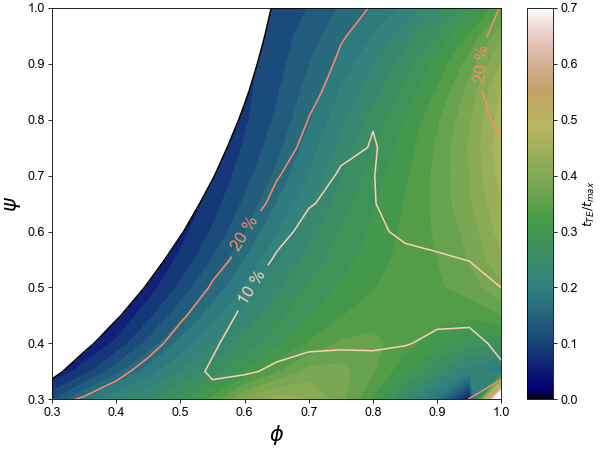

(225,)
(225, 20) (225, 1) (20,)


<IPython.core.display.Javascript object>


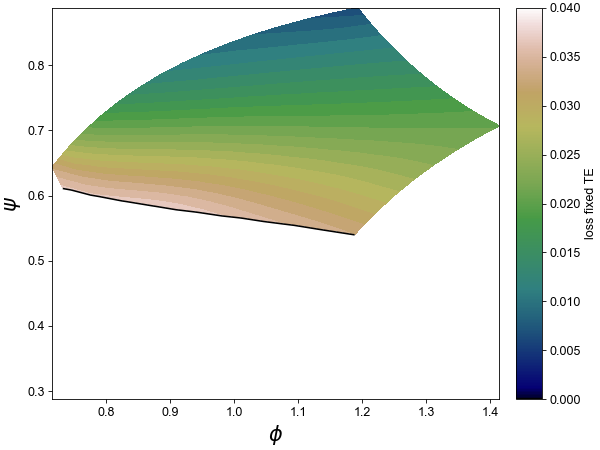

<IPython.core.display.Javascript object>


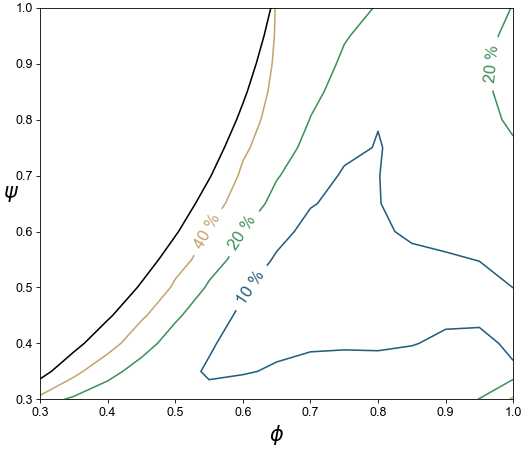

In [364]:
N=15
fig2 = plt.figure(constrained_layout=True,figsize=(8,6))
ax = fig2.add_subplot(111)    
norm =  matplotlib.colors.Normalize(vmin=0.00,vmax=0.7)
te = 0.33
cos_in_vec, cos_out, DHV, V1_UV = angles(PHI_vec,PSI_vec)
loss, lost_eff, PHI, PSI, DH,V1_U,sc,gc, cos_in, cos_out, H23,Cd,V3 = sample_smith(H,tc,te,N,3.5,0.00)
lost_eff = loss.flatten()*((V1_U.flatten())**2)/PSI.flatten()
#surf = ax.contourf(np.reshape(V1_UV,(N,N)), np.reshape(DHV,(N,N)), np.reshape(TEMIN_vec,(N,N)),levels=40,norm=norm,cmap=cm.gist_earth)
#surf = ax.contourf(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
#surf = ax.contour(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
#ax.set_xlabel('$V_{1}/U$',fontsize=20)
#h=ax.set_ylabel('DH',fontsize=20)
#fig2.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.gist_earth), ax=ax, label = '$t_{TE}/t_{max}$')
surf = ax.contourf(np.reshape(PHI_vec,(N,N)), np.reshape(PSI_vec,(N,N)), np.reshape(TEMIN_vec,(N,N)),levels=40,norm=norm,cmap=cm.gist_earth)
surf = ax.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
surf = ax.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])


ax.set_xlabel('$\phi$',fontsize=20)
h=ax.set_ylabel('$\psi$',fontsize=20)
fig2.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.gist_earth), ax=ax, label = '$t_{TE}/t_{max}$') 
norm =  matplotlib.colors.Normalize(vmin=0.0,vmax=50)

surf = ax.contour(np.reshape(PHI_vec,(N,N)), np.reshape(PSI_vec,(N,N)), np.reshape(100*LOSS_DEL/LOSS,(N,N)),levels=[10, 20], norm = norm,cmap=cm.Reds)
ax.clabel(surf, surf.levels, inline=True, fmt=fmt, fontsize=16)


plt.savefig('optimum.png')
def fmt(x):
    s = f"{x:.1f}"
    if s.endswith("0"):
        s = f"{x:.0f}"
    return rf"{s} \%" if plt.rcParams["text.usetex"] else f"{s} %"


fig3 = plt.figure(constrained_layout=True,figsize=(8,6))
ax2 = fig3.add_subplot(111)    
norm =  matplotlib.colors.Normalize(vmin=0.0,vmax=0.04)

#surf = ax2.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(loss,(N,N)),levels=40,norm=norm,cmap=cm.gist_earth)
#surf = ax2.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
#surf = ax2.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])

surf = ax2.contourf(np.reshape(V1_UV,(N,N)), np.reshape(DHV,(N,N)), np.reshape(LOSS,(N,N)),levels=80,norm=norm,cmap=cm.gist_earth)
surf = ax2.contourf(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
surf = ax2.contour(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
ax2.set_xlabel('$\phi$',fontsize=20)
h=ax2.set_ylabel('$\psi$',fontsize=20)
fig3.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.gist_earth), ax=ax2, label = 'loss fixed TE') 


fig4 = plt.figure(constrained_layout=True,figsize=(7,6))
ax3 = fig4.add_subplot(111)    
norm =  matplotlib.colors.Normalize(vmin=0.0,vmax=50)

surf = ax3.contour(np.reshape(PHI_vec,(N,N)), np.reshape(PSI_vec,(N,N)), np.reshape(100*LOSS_DEL/LOSS,(N,N)),levels=[10, 20, 40], norm = norm,cmap=cm.gist_earth)

surf2 = ax3.contourf(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
surf2 = ax3.contour(np.reshape(PHI,(N,N)), np.reshape(PSI,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
ax3.clabel(surf, surf.levels, inline=True, fmt=fmt, fontsize=16)
#surf = ax3.contourf(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(lost_eff,(N,N)),levels=80,norm=norm,cmap=cm.gist_earth)
#surf = ax3.contourf(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'w',levels=[0,0.15])
#surf = ax3.contour(np.reshape(V1_U,(N,N)), np.reshape(DH,(N,N)), np.reshape(gc,(N,N)),colors = 'k',levels=[0.15])
ax3.set_xlabel('$\phi$',fontsize=20)
h=ax3.set_ylabel('$\psi$',fontsize=20,rotation=0)
plt.savefig('sensitivity.png')
#fig4.colorbar(cm.ScalarMappable(norm=norm,cmap=cm.Reds), ax=ax3, label = 'Log variation in loss as fraction of minimum loss') 